In [ ]:
import pandas as pd
import numpy as np
import os
import math
import glob
from datetime import datetime
from datetime import timedelta
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas") # ignore pandas warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib") # ignore matplotlib warnings

In [2]:
cemaden_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY_V3.h5'
# cemaden_path = r'C:\Users\linde\OneDrive\Hidroweb\Consolidated Files\BRASIL_CEMADEN_TOTAL_DAILY.h5'
cemaden_path_v2 = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY_V2.h5'
neighboring_data_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET'

In [3]:
def calculate_quality_label(row):
    if row['quality_index'] >= 90 and row['p_availability'] >= 99:
        return '1 - Excellent Quality'
    elif row['quality_index'] >= 85 and row['p_availability'] >= 95:
        return '2 - Good Quality'
    elif row['quality_index'] >= 80 and row['p_availability'] >= 90:
        return '3 - Acceptable Quality'
    elif row['quality_index'] >= 50:
        return '4 - Low Quality'
    else:
        return '5 - Very Low Quality'

In [4]:
def absolute_quality_label(row):
    if row['quality_label'] in ['Excellent Quality', 'Good Quality', 'Acceptable Quality']:
        return 'HQ'
    elif row['quality_label'] in ['Low Quality', 'Very Low Quality']:
        return 'LQ'
    else:
        return 'Unknown'

# Reading data

In [ ]:
df_cemaden_data = pd.read_hdf(cemaden_path, key='table_data')
df_cemaden_data.rename(columns={'date': 'datetime'}, inplace=True)
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year
df_cemaden_data = df_cemaden_data[(df_cemaden_data['year']<= 2020)
                                    & (df_cemaden_data['rain_mm']>= 0.0)
                                    & (df_cemaden_data['rain_mm']<= 600.0)
                                    ].reset_index(drop=True)
df_cemaden_data

,gauge_code,datetime,rain_mm,year
0,120040101A,2014-02-01,26.947336,2014
1,120040101A,2014-02-02,7.092065,2014
2,120040101A,2014-02-03,0.792680,2014
3,120040101A,2014-02-04,0.600000,2014
4,120040101A,2014-02-05,0.600000,2014
...,...,...,...,...
6808963,172210701A,2020-12-27,0.200000,2020
6808964,172210701A,2020-12-28,0.000000,2020
6808965,172210701A,2020-12-29,27.030000,2020
6808966,172210701A,2020-12-30,0.200000,2020


In [6]:
df_cemaden_data['year'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [7]:
df_cemaden_data['rain_mm'].describe()

count    6.808968e+06
mean     3.250418e+00
std      9.867989e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.994800e+02
Name: rain_mm, dtype: float64

In [8]:
# df_cemaden_data = pd.read_hdf(cemaden_path, key='table_data')
# df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year
# df_cemaden_data = df_cemaden_data[(df_cemaden_data['year']<= 2020)
#                                     & (df_cemaden_data['rain_mm']>= 0.0)
#                                     & (df_cemaden_data['rain_mm']<= 600.0)
#                                     ].reset_index(drop=True)
# df_cemaden_data

# # 130 acima de 600mm

In [9]:
df_cemaden_info = pd.read_hdf(cemaden_path, key = 'table_info')
df_cemaden_info['lat'] = df_cemaden_info['lat'].astype(float)
df_cemaden_info['long'] = df_cemaden_info['long'].astype(float)
df_cemaden_info.sort_values(['lat', 'long'], inplace=True)
df_cemaden_info.reset_index(drop=True, inplace=True)
df_cemaden_info

,gauge_code,state,city,name_station,long,lat
0,431100701A,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
1,430130501A,RS,ARROIO GRANDE,Centro,-53.085622,-32.238669
2,431420901A,RS,PEDRO OSÓRIO,Centro,-52.826981,-31.867047
3,431440702A,RS,PELOTAS,Centro,-52.342000,-31.770000
4,430466301A,RS,CAPÃO DO LEÃO,Centro,-52.764151,-31.764166
...,...,...,...,...,...,...
4173,140010003A,RR,BOA VISTA,Pricumã,-60.692624,2.804488
4174,140010002A,RR,BOA VISTA,Calunga,-60.674663,2.806589
4175,140010005A,RR,BOA VISTA,Caranã,-60.719258,2.844432
4176,140010001A,RR,BOA VISTA,Paraviana,-60.658979,2.859961


In [10]:
len(df_cemaden_data['gauge_code'].unique())

4178

In [11]:
years = df_cemaden_data['year'].sort_values(ascending=True).drop_duplicates().values.tolist()
years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [12]:
df_complete_info = pd.merge(df_cemaden_data, df_cemaden_info, on='gauge_code', how = 'inner').sort_values('lat', ascending = True).reset_index(drop=True)   
df_complete_info

,gauge_code,datetime,rain_mm,year,state,city,name_station,long,lat
0,431100701A,2018-03-31,0.20,2018,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
1,431100701A,2020-11-18,5.20,2020,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
2,431100701A,2020-11-17,0.00,2020,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
3,431100701A,2020-11-16,0.00,2020,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
4,431100701A,2020-11-15,0.00,2020,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
...,...,...,...,...,...,...,...,...,...
6808963,140070401A,2019-08-26,0.00,2019,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6808964,140070401A,2019-08-27,0.00,2019,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6808965,140070401A,2019-08-28,0.00,2019,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6808966,140070401A,2018-11-07,0.00,2018,RR,UIRAMUTÃ,Centro,-60.162963,4.594482


# Preclassif

In [13]:
# Add a year column to the dataframe
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year

# Group by gauge_code and year
grouped = df_cemaden_data.groupby(['gauge_code', 'year'])

# Calculate annual_rainfall_mm, active_days, and consecutive_dry_days
def calculate_metrics(group):
    annual_rainfall_mm = group['rain_mm'].sum()
    active_days = (group['rain_mm'] >= 0.0).sum()
    
    # Calculate consecutive dry days
    dry_days = (group['rain_mm'] == 0.0).astype(int)
    # Calculate the maximum number of consecutive dry days
    consecutive_dry_days = (dry_days.groupby((dry_days != dry_days.shift()).cumsum()).cumsum() * dry_days).max()
    
    return pd.Series({
        'annual_rainfall_mm': annual_rainfall_mm,
        'active_days': active_days,
        'consecutive_dry_days': consecutive_dry_days
    })

In [14]:
df_preclassif = grouped.apply(calculate_metrics).reset_index()
df_preclassif['preclassif'] = df_preclassif.apply(
    lambda row: 'LQ' if (row['annual_rainfall_mm'] < 300 or row['annual_rainfall_mm'] > 6000
                        #  or row['active_days'] < 305
                         or row['consecutive_dry_days'] > 200) else "", axis=1)
df_preclassif

C:\Users\linde\AppData\Local\Temp\ipykernel_9232\3678795309.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preclassif = grouped.apply(calculate_metrics).reset_index()


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,110018901A,2018,969.740000,136.0,21.0,
1,110018901A,2019,1786.230000,365.0,58.0,
2,110018901A,2020,347.270000,366.0,328.0,LQ
3,110020501A,2014,108.270409,16.0,2.0,LQ
4,110020501A,2017,138.460000,92.0,55.0,LQ
...,...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0,
22769,CEMADEN_12,2020,398.050000,31.0,1.0,
22770,CEMADEN_13,2019,51.800000,30.0,12.0,LQ
22771,CEMADEN_14,2018,436.400000,92.0,3.0,


In [15]:
preclassif_counts = df_preclassif['preclassif'].value_counts()
print(preclassif_counts)

preclassif
      18278
LQ     4495
Name: count, dtype: int64


In [16]:
preclassif_counts['LQ'] / preclassif_counts.sum()

0.19738286567426339

In [17]:
df_preclassif.to_hdf(cemaden_path, key='table_preclassif', mode='r+', complevel=9, format='table', append=False, index=False)
df_preclassif

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,110018901A,2018,969.740000,136.0,21.0,
1,110018901A,2019,1786.230000,365.0,58.0,
2,110018901A,2020,347.270000,366.0,328.0,LQ
3,110020501A,2014,108.270409,16.0,2.0,LQ
4,110020501A,2017,138.460000,92.0,55.0,LQ
...,...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0,
22769,CEMADEN_12,2020,398.050000,31.0,1.0,
22770,CEMADEN_13,2019,51.800000,30.0,12.0,LQ
22771,CEMADEN_14,2018,436.400000,92.0,3.0,


# Outlier treatment

In [18]:
df_outlier = pd.merge(df_complete_info[['gauge_code', 'rain_mm', 'datetime', 'year']]
                      , df_preclassif
                      , on = ['gauge_code', 'year']
                      , how = 'inner')
df_outlier = df_outlier[['gauge_code',	'datetime',	'rain_mm']]
df_outlier

,gauge_code,datetime,rain_mm
0,431100701A,2018-03-31,0.20
1,431100701A,2020-11-18,5.20
2,431100701A,2020-11-17,0.00
3,431100701A,2020-11-16,0.00
4,431100701A,2020-11-15,0.00
...,...,...,...
6808963,140070401A,2019-08-26,0.00
6808964,140070401A,2019-08-27,0.00
6808965,140070401A,2019-08-28,0.00
6808966,140070401A,2018-11-07,0.00


In [19]:
def mark_outlier_rain(df, threshold_rain_mm=200):
    # Garantir que a coluna 'datetime' está no formato datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    df_yesterday = df.copy(deep = True)
    df_yesterday['datetime'] = df_yesterday['datetime'] + pd.Timedelta(days=1)
    df_tomorrow = df.copy(deep = True)
    df_tomorrow['datetime'] = df_tomorrow['datetime'] - pd.Timedelta(days=1)

    df = pd.merge(df, df_yesterday[['gauge_code', 'datetime', 'rain_mm']], on=['gauge_code', 'datetime'], how='left', suffixes=('', '_yesterday'))
    df = pd.merge(df, df_tomorrow[['gauge_code', 'datetime', 'rain_mm']], on=['gauge_code', 'datetime'], how='left', suffixes=('', '_tomorrow'))
    df_sorted = df.sort_values(['gauge_code', 'datetime']).reset_index(drop=True)

    # Calcular soma da chuva nos dias adjacentes
    df_sorted['adjacent_days_mm'] = df_sorted['rain_mm_yesterday'] + df_sorted['rain_mm_tomorrow']

    # Regra para identificar outlier
    condition = (
        (df_sorted['rain_mm'] > threshold_rain_mm) &
        (df_sorted['adjacent_days_mm'] < 0.025 * df_sorted['rain_mm'])
    )

    df_sorted['outlier_status_1'] = np.where(condition, 1, 0)

    return df_sorted

# Aplicar na base df_outlier_filter_1
df_outlier_filter_1 = mark_outlier_rain(df_outlier)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,rain_mm_yesterday,rain_mm_tomorrow,adjacent_days_mm,outlier_status_1
0,110018901A,2018-08-18,15.66,NaN,12.22,NaN,0
1,110018901A,2018-08-19,12.22,15.66,0.00,15.66,0
2,110018901A,2018-08-20,0.00,12.22,0.00,12.22,0
3,110018901A,2018-08-21,0.00,0.00,0.00,0.00,0
4,110018901A,2018-08-22,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
6808963,CEMADEN_14,2019-04-26,0.00,0.00,0.00,0.00,0
6808964,CEMADEN_14,2019-04-27,0.00,0.00,0.00,0.00,0
6808965,CEMADEN_14,2019-04-28,0.00,0.00,6.20,6.20,0
6808966,CEMADEN_14,2019-04-29,6.20,0.00,0.00,0.00,0


In [20]:
nan_count = df_outlier_filter_1['adjacent_days_mm'].isna().sum()
print(f"Number of rows where adjacent_days_mm is NaN: {nan_count}")

Number of rows where adjacent_days_mm is NaN: 16708


In [21]:
df_outlier_filter_1_export = df_outlier_filter_1[df_outlier_filter_1['outlier_status_1'] == 1]
df_outlier_filter_1_export.to_hdf(
        os.path.join(neighboring_data_path, "adjacent_day_analysis_filter_1.h5"),
        key='table_data',
        mode='w',
        format='table',
        complevel=9,
        encoding='utf-8',
        append=False,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
df_outlier_filter_1_export

,gauge_code,datetime,rain_mm,rain_mm_yesterday,rain_mm_tomorrow,adjacent_days_mm,outlier_status_1
3811,120032801A,2020-11-23,218.80,0.0,0.0,0.0,1
33844,130353602A,2019-03-23,233.30,0.0,0.0,0.0,1
91650,150480202A,2019-11-17,240.20,0.0,1.0,1.0,1
92807,150480203A,2019-11-17,239.60,0.0,2.6,2.6,1
308950,211130007A,2016-01-23,213.60,0.0,3.8,3.8,1
...,...,...,...,...,...,...,...
6262565,421820202A,2020-04-23,241.89,0.0,0.0,0.0,1
6262582,421820202A,2020-05-11,202.85,0.0,0.0,0.0,1
6262652,421820202A,2020-07-20,431.55,1.0,0.0,1.0,1
6534725,431640202A,2018-03-24,253.80,0.0,0.8,0.8,1


In [22]:
df_outlier_filter_1 = df_outlier_filter_1[['gauge_code','datetime',	'rain_mm', 'outlier_status_1']]
df_outlier_filter_1 = pd.merge(df_outlier_filter_1, df_cemaden_info[['gauge_code', 'lat', 'long']], on ='gauge_code', how='left')
df_outlier_filter_1.sort_values(['gauge_code', 'datetime'], ascending=True, inplace=True)
df_outlier_filter_1.reset_index(drop=True, inplace=True)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,outlier_status_1,lat,long
0,110018901A,2018-08-18,15.66,0,-11.683234,-61.182871
1,110018901A,2018-08-19,12.22,0,-11.683234,-61.182871
2,110018901A,2018-08-20,0.00,0,-11.683234,-61.182871
3,110018901A,2018-08-21,0.00,0,-11.683234,-61.182871
4,110018901A,2018-08-22,0.00,0,-11.683234,-61.182871
...,...,...,...,...,...,...
6808963,CEMADEN_14,2019-04-26,0.00,0,-22.682199,-45.000316
6808964,CEMADEN_14,2019-04-27,0.00,0,-22.682199,-45.000316
6808965,CEMADEN_14,2019-04-28,0.00,0,-22.682199,-45.000316
6808966,CEMADEN_14,2019-04-29,6.20,0,-22.682199,-45.000316


In [23]:
def idw_interpolation(latitude, longitude, df_temp_without_gauge, kdtree, p=2):
    row = [latitude, longitude]
    distances, indices = kdtree.query(row, k=5)
    weights = 1 / (distances + 1e-6) ** p
    values = df_temp_without_gauge.iloc[indices]['rain_mm'].values
    return (np.sum(weights * values) / np.sum(weights))

# Initialize empty DataFrame for results
outlier_analysis_results = pd.DataFrame()

# Configurations
output_filename = os.path.join(neighboring_data_path, "neighboring_analysis.h5")
rainfall_threshold = 200.0  # mm

start_date = '2014-01-01'
end_date = '2020-12-31'

df_date = df_outlier_filter_1.loc[(df_outlier_filter_1['datetime'] >= start_date) & (df_outlier_filter_1['datetime'] <= end_date)].sort_values('datetime', ignore_index=True, ascending=True)

df_date_filter = df_date[df_date['rain_mm'] > 200.0].reset_index(drop=True) # Filter for high rainfall values

# Get sorted unique dates
analysis_dates = df_date_filter['datetime'].unique().tolist() # Get unique dates for the analysis
analysis_dates.sort()

# Process each date
for current_date in analysis_dates[:]:
    # Filter data for current date
    daily_data = df_outlier_filter_1[df_outlier_filter_1['datetime'] == current_date]
    
    df_gauge_filter = daily_data[daily_data['rain_mm'] > 200.0].reset_index(drop=True) # Filter for high rainfall values
    
    gauge_codes = df_gauge_filter['gauge_code'].unique() # Get unique gauge codes for the current date
    
    date_results = []
    
    for gauge in gauge_codes:
        gauge_data = daily_data[daily_data['gauge_code'] == gauge].iloc[0]
        lat, lon = gauge_data['lat'], gauge_data['long']
        observed_rain = gauge_data['rain_mm']
        
        # Initialize result row
        result_row = {
            'gauge_code': gauge,
            'datetime': current_date,
            'lat': lat,
            'long': lon,
            'observed_rain_mm': observed_rain,
            'interpolated_rain_mm': np.nan
        }
        
        # Only interpolate for high rainfall values
        if observed_rain > rainfall_threshold:
            neighbor_data = daily_data[daily_data['gauge_code'] != gauge]
            
            if len(neighbor_data) > 0:
                kd_tree = KDTree(neighbor_data[['lat', 'long']].values)
                result_row['interpolated_rain_mm'] = idw_interpolation(lat, lon, neighbor_data, kd_tree)
        
        date_results.append(pd.DataFrame([result_row]))
    
    # Combine results for current date
    daily_results = pd.concat(date_results, ignore_index=True)
    
    # Save to HDF5 with proper configuration
    storage_mode = 'w' if current_date == analysis_dates[0] else 'a'
    append_mode = False if current_date == analysis_dates[0] else True

    # storage_mode = 'r+'
    # append_mode = True
    
    daily_results.to_hdf(
        output_filename,
        key='table_data',
        mode=storage_mode,
        format='table',
        complevel=9,
        encoding='utf-8',
        append=append_mode,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
    
    print(f"Saved results for {current_date} to {output_filename}")

Saved results for 2014-02-01 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-02-09 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-02-15 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-03-22 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-03-27 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-03-30 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-04-03 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-04-10 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-04-14 00:

In [24]:
output_filename = os.path.join(neighboring_data_path, "neighboring_analysis.h5")
df_outlier_2 = pd.read_hdf(output_filename, key='table_data')
df_outlier_2

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm
0,351870116A,2014-02-01,-23.907000,-46.164000,245.369766,0.000000
0,230440013A,2014-02-09,-3.794083,-38.501833,384.763400,1.939648
0,352990601A,2014-02-15,-24.283000,-47.456000,274.084072,129.955405
1,355540607A,2014-02-15,-23.517000,-45.196000,211.519555,146.649750
2,355540613A,2014-02-15,-23.419000,-45.066000,203.908136,177.684821
...,...,...,...,...,...,...
0,311320603A,2020-12-13,-20.953000,-43.807000,429.870000,4.093817
0,311320603A,2020-12-17,-20.953000,-43.807000,247.430000,32.022253
0,330250202A,2020-12-22,-22.576000,-43.188000,256.080000,146.032939
1,330250203A,2020-12-22,-22.594000,-43.183000,251.560000,184.869007


In [25]:
df_outlier_filter_2_export = df_outlier_2[df_outlier_2['interpolated_rain_mm'] >= 0.0].reset_index(drop = True)
df_outlier_filter_2_export = df_outlier_filter_2_export[df_outlier_filter_2_export['interpolated_rain_mm'] >= 0.35 * df_outlier_filter_2_export['observed_rain_mm']]
df_outlier_filter_2_export['outlier_status_2'] = 1
df_outlier_filter_2_export

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm,outlier_status_2
2,352990601A,2014-02-15,-24.283,-47.456,274.084072,129.955405,1
3,355540607A,2014-02-15,-23.517,-45.196,211.519555,146.649750,1
4,355540613A,2014-02-15,-23.419,-45.066,203.908136,177.684821,1
5,330010013A,2014-03-22,-22.902,-44.332,219.237016,145.883307,1
10,355070402A,2014-04-14,-23.758,-45.764,226.889704,133.107588,1
...,...,...,...,...,...,...,...
333,351870121A,2020-03-03,-23.994,-46.276,212.260000,137.185217,1
334,354850009A,2020-03-03,-23.891,-46.189,204.430000,163.606467,1
369,330250202A,2020-12-22,-22.576,-43.188,256.080000,146.032939,1
370,330250203A,2020-12-22,-22.594,-43.183,251.560000,184.869007,1


In [26]:
df_outlier_filter_2_export.to_hdf(
        os.path.join(neighboring_data_path, "neighboring_analysis_filter_2.h5"),
        key='table_data',
        mode='w',
        format='table',
        complevel=9,
        encoding='utf-8',
        append=False,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
df_outlier_filter_2_export

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm,outlier_status_2
2,352990601A,2014-02-15,-24.283,-47.456,274.084072,129.955405,1
3,355540607A,2014-02-15,-23.517,-45.196,211.519555,146.649750,1
4,355540613A,2014-02-15,-23.419,-45.066,203.908136,177.684821,1
5,330010013A,2014-03-22,-22.902,-44.332,219.237016,145.883307,1
10,355070402A,2014-04-14,-23.758,-45.764,226.889704,133.107588,1
...,...,...,...,...,...,...,...
333,351870121A,2020-03-03,-23.994,-46.276,212.260000,137.185217,1
334,354850009A,2020-03-03,-23.891,-46.189,204.430000,163.606467,1
369,330250202A,2020-12-22,-22.576,-43.188,256.080000,146.032939,1
370,330250203A,2020-12-22,-22.594,-43.183,251.560000,184.869007,1


In [27]:
df_filter_1 = pd.read_hdf(os.path.join(neighboring_data_path, "adjacent_day_analysis_filter_1.h5"), key='table_data')
df_filter_1 = df_filter_1[['gauge_code', 'datetime', 'outlier_status_1']]
df_filter_1

,gauge_code,datetime,outlier_status_1
3811,120032801A,2020-11-23,1
33844,130353602A,2019-03-23,1
91650,150480202A,2019-11-17,1
92807,150480203A,2019-11-17,1
308950,211130007A,2016-01-23,1
...,...,...,...
6262565,421820202A,2020-04-23,1
6262582,421820202A,2020-05-11,1
6262652,421820202A,2020-07-20,1
6534725,431640202A,2018-03-24,1


In [28]:
df_filter_2 = pd.read_hdf(os.path.join(neighboring_data_path, "neighboring_analysis_filter_2.h5"), key='table_data')
# df_filter_2['outlier_status_2'] = 1
df_filter_2 = df_filter_2[['gauge_code', 'datetime', 'outlier_status_2']]
df_filter_2

,gauge_code,datetime,outlier_status_2
2,352990601A,2014-02-15,1
3,355540607A,2014-02-15,1
4,355540613A,2014-02-15,1
5,330010013A,2014-03-22,1
10,355070402A,2014-04-14,1
...,...,...,...
333,351870121A,2020-03-03,1
334,354850009A,2020-03-03,1
369,330250202A,2020-12-22,1
370,330250203A,2020-12-22,1


In [29]:
df_data_filtered = pd.merge(df_cemaden_data, df_filter_1, on = ['gauge_code', 'datetime'], how = 'left').merge(df_filter_2, on = ['gauge_code', 'datetime'], how = 'left')
df_data_filtered = df_data_filtered[(df_data_filtered['outlier_status_1'] != 1) & (df_data_filtered['outlier_status_2'] != 1)]
df_data_filtered = df_data_filtered[['gauge_code', 'datetime', 'rain_mm']].copy(deep = True)
df_data_filtered.to_hdf(cemaden_path, key='table_data_filtered', mode='r+', format='table', index=False, complevel=9, complib='zlib', append=False, encoding='utf-8', min_itemsize={'gauge_code': 20})
df_data_filtered

,gauge_code,datetime,rain_mm
0,120040101A,2014-02-01,26.947336
1,120040101A,2014-02-02,7.092065
2,120040101A,2014-02-03,0.792680
3,120040101A,2014-02-04,0.600000
4,120040101A,2014-02-05,0.600000
...,...,...,...
6808963,172210701A,2020-12-27,0.200000
6808964,172210701A,2020-12-28,0.000000
6808965,172210701A,2020-12-29,27.030000
6808966,172210701A,2020-12-30,0.200000


In [30]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['preclassif', 'table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Filtered Data

In [31]:
df_cemaden_data = pd.read_hdf(cemaden_path, key='table_data_filtered')
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year
df_cemaden_data = df_cemaden_data[(df_cemaden_data['year'] <= 2020)
                                    & (df_cemaden_data['rain_mm']>= 0.0)
                                    & (df_cemaden_data['rain_mm']<= 600.0)].reset_index(drop=True)
df_cemaden_data
# filtered version of the dataset

,gauge_code,datetime,rain_mm,year
0,120040101A,2014-02-01,26.947336,2014
1,120040101A,2014-02-02,7.092065,2014
2,120040101A,2014-02-03,0.792680,2014
3,120040101A,2014-02-04,0.600000,2014
4,120040101A,2014-02-05,0.600000,2014
...,...,...,...,...
6808729,172210701A,2020-12-27,0.200000,2020
6808730,172210701A,2020-12-28,0.000000,2020
6808731,172210701A,2020-12-29,27.030000,2020
6808732,172210701A,2020-12-30,0.200000,2020


In [32]:
df_cemaden_data['gauge_code'].nunique()

4178

# Parameters

In [33]:
wet_day_mm = 1.0

# P

In [34]:
def calculateP(df):
    station_list = df['gauge_code'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
    df_result = pd.DataFrame(columns = ["gauge_code", "year", "p_availability"])
    count = 0
    for station in station_list:
        count = count + 1
        # print(count, '/', len(station_list))
        list_gauge_code = []
        list_year = []
        list_p_availabity = []
        df_temp_station = df[(df['gauge_code'] == station)]
        year_list = df_temp_station['year'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
        for year in year_list:
            df_temp_station_year = df_temp_station[(df_temp_station['year'] == year)]
            first_day = datetime(year, 1, 1)
            last_day = datetime(year + 1, 1, 1)
            year_length = (last_day - first_day).days
            row_count = len(df_temp_station_year)
            yearly_availabity = row_count / year_length * 100.0
            list_gauge_code.append(station)
            list_year.append(year)
            list_p_availabity.append(yearly_availabity)
        df_station_availabity = pd.DataFrame(list(zip(list_gauge_code, list_year, list_p_availabity)), columns =['gauge_code', 'year', 'p_availability'])
        if df_result.empty:
            df_result = df_station_availabity.copy(deep=True)
        else:
            df_result = pd.concat([df_result, df_station_availabity], ignore_index = True)
    return df_result.sort_values(['gauge_code', 'year'])

In [35]:
df_p_availability = calculateP(df_cemaden_data)
df_p_availability

,gauge_code,year,p_availability
14399,110018901A,2018,37.260274
14400,110018901A,2019,100.000000
14401,110018901A,2020,100.000000
14391,110020501A,2014,4.383562
14392,110020501A,2017,25.205479
...,...,...,...
22645,CEMADEN_12,2019,24.657534
22646,CEMADEN_12,2020,8.469945
22701,CEMADEN_13,2019,8.219178
22647,CEMADEN_14,2018,25.205479


In [36]:
df_p_availability = df_p_availability[['gauge_code', 'year', 'p_availability']]
df_p_availability.to_hdf(cemaden_path, key = 'table_p_availability', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_p_availability

,gauge_code,year,p_availability
14399,110018901A,2018,37.260274
14400,110018901A,2019,100.000000
14401,110018901A,2020,100.000000
14391,110020501A,2014,4.383562
14392,110020501A,2017,25.205479
...,...,...,...
22645,CEMADEN_12,2019,24.657534
22646,CEMADEN_12,2020,8.469945
22701,CEMADEN_13,2019,8.219178
22647,CEMADEN_14,2018,25.205479


In [37]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['preclassif', 'table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q1

In [38]:
def calculateQ1(df):
    station_list = df['gauge_code'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
    df_result = pd.DataFrame(columns = ["gauge_code", "year", "q1_gaps"])
    count = 0
    for station in station_list:
        count = count + 1
        print(count, '/', len(station_list))
        list_gauge_code = []
        list_year = []
        list_q1_gaps = []
        df_temp_station = df[(df['gauge_code'] == station)]
        year_list = df_temp_station['year'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
        for year in year_list:
            # print(station, year)
            df_temp_station_year = df_temp_station[(df_temp_station['year'] == year)]
            active_days = df_temp_station_year['datetime'].nunique()
            min_date = min(df_temp_station_year['datetime'])
            max_date = max(df_temp_station_year['datetime'])
            first_day = datetime(year, 1, 1)
            last_day = datetime(year + 1, 1, 1)
            date_list = []
            today = first_day
            while today < last_day:
                date_list.append(today)
                today = today + timedelta(days=1)
            df_date_list = pd.DataFrame(date_list, columns=['datetime'])
            count_ops = len(df_date_list)
            df_date_list = df_date_list[(df_date_list['datetime'] >= min_date) & (df_date_list['datetime'] <= max_date)]
            df_analysis = df_date_list.merge(df_temp_station_year, how = 'left', on  = 'datetime')
            df_analysis = df_analysis.sort_values(['datetime'], ignore_index=True)
            df_void = df_analysis[(df_analysis['rain_mm'].isnull())]
            df_void = df_void.sort_values(['datetime'], ignore_index=True)
            count_gaps = len(df_void)
            gap_series = df_analysis['rain_mm'].values.tolist()
            gap_count = 0
            gap_max_len = 0
            for value in gap_series:
                if math.isnan(value):
                    gap_count = gap_count + 1
#                     print(value, "gap count is", gap_count)
                    if gap_count > gap_max_len:
                        gap_max_len = gap_count
#                         print(value, "new gap max len", gap_max_len)
                else:
                    gap_count = 0
#                     print(value, "gap count is zero", gap_count)
            # print("count_gaps", count_gaps)
            # print("count_ops", count_ops)
            # print("gap_max_len", gap_max_len)
            q_gap = 100.0 - 100.0 * (((2.0 * count_gaps) + gap_max_len)/active_days)
            if (q_gap < 0.0):
                q_gap = 0.0
            print("q_gap", q_gap)
            list_gauge_code.append(station)
            list_year.append(year)
            list_q1_gaps.append(q_gap)
        df_station_gaps = pd.DataFrame(list(zip(list_gauge_code, list_year, list_q1_gaps)), columns =['gauge_code', 'year', 'q1_gaps'])
        if df_result.empty:
            df_result = df_station_gaps.copy(deep=True)
        else:
            df_result = pd.concat([df_result, df_station_gaps], ignore_index = True)
    return df_result

In [39]:
df_q1_gaps = calculateQ1(df_cemaden_data)

1 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
2 / 4178
q_gap 100.0
q_gap 100.0
3 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
4 / 4178
q_gap 100.0
q_gap 100.0
5 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
6 / 4178
q_gap 100.0
q_gap 100.0
q_gap 99.17808219178082
7 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
8 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
9 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
10 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
11 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
12 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
13 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
14 / 4178
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
q_gap 100.0
15 / 4178
q_gap 1

In [40]:
df_q1_gaps.to_hdf(cemaden_path, key = 'table_q1_gaps', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q1_gaps

,gauge_code,year,q1_gaps
0,120040101A,2014,100.0
1,120040101A,2015,100.0
2,120040101A,2016,100.0
3,120040101A,2017,100.0
4,120040101A,2020,100.0
...,...,...,...
22768,171820401A,2019,100.0
22769,171820401A,2020,100.0
22770,172210701A,2018,100.0
22771,172210701A,2019,100.0


In [41]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['preclassif', 'table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q2

In [42]:
def calculateQ2(df):
    station_list = df['gauge_code'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
    df_result = pd.DataFrame(columns = ["gauge_code", "year", "q2_week"])
    count = 0
    for station in station_list:
        count = count + 1
        print(count, '/', len(station_list))
        list_gauge_code = []
        list_year = []
        list_q2_week = []
        df_temp_station = df[(df['gauge_code'] == station)]
        year_list = df_temp_station['year'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
        for year in year_list:
            # print(station, year)
            df_temp_station_year = df_temp_station[(df_temp_station['year'] == year)]
            # count_ops = len(df_temp_station_year)
            first_day = datetime(year, 1, 1)
            last_day = datetime(year + 1, 1, 1) 
            date_list = []
            today = first_day
            while today < last_day:
                date_list.append(today)
                today = today + timedelta(days=1)
            df_date_list = pd.DataFrame(date_list, columns=['datetime'])      
            df_analysis = df_date_list.merge(df_temp_station_year, how = 'left', on  = 'datetime')
            df_analysis = df_analysis.sort_values(['datetime'], ignore_index=True)
            # len_period = len(df_analysis)
            df_analysis['q2_week'] = df_analysis['datetime'].dt.dayofweek
            df_rainy = df_analysis[df_analysis['rain_mm'] > 0]
            df_rainy = df_rainy.reset_index(drop = True, inplace = False)
            df_count = df_rainy[['q2_week','rain_mm']].groupby(['q2_week']).count()
            rainy_mean = float(df_count.mean())
            rainy_std = float(df_count.std())
            cv = 0.0
            if rainy_std > 0.0:
                cv = rainy_std/rainy_mean
            q_weekday = 100 - 100*cv
            # print(q_weekday)
            list_gauge_code.append(station)
            list_year.append(year)
            list_q2_week.append(q_weekday)
        df_station_weekday = pd.DataFrame(list(zip(list_gauge_code, list_year, list_q2_week)), columns =['gauge_code', 'year', 'q2_week'])
        if df_result.empty:
            df_result = df_station_weekday.copy(deep=True)
        else:
            df_result = pd.concat([df_result, df_station_weekday], ignore_index = True)
    return df_result



In [ ]:
df_q2_week = calculateQ2(df_cemaden_data)
df_q2_week

In [44]:
df_q2_week = pd.merge(df_q2_week, df_p_availability[['gauge_code', 'year']], on = ['gauge_code', 'year'], how = 'outer').reset_index(drop=True).fillna(0).sort_values(['gauge_code'], ascending = True)
df_q2_week.rename(columns={'q2_weekday': 'q2_week'}, inplace=True)
df_q2_week.to_hdf(cemaden_path, key = 'table_q2_week', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q2_week

,gauge_code,year,q2_week
0,110018901A,2018,79.213015
1,110018901A,2019,91.236742
2,110018901A,2020,67.725139
3,110020501A,2014,65.984933
4,110020501A,2017,61.509982
...,...,...,...
22767,CEMADEN_12,2018,77.777778
22768,CEMADEN_12,2019,90.159144
22770,CEMADEN_13,2019,64.644661
22771,CEMADEN_14,2018,78.723842


In [45]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['preclassif', 'table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q3

In [46]:
def calculateQ3(df):
    station_list = df['gauge_code'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
    df_result = pd.DataFrame(columns = ["gauge_code", "year", "q3_outliers"])
    count = 0
    for station in station_list:
        count = count + 1
        print(count, '/', len(station_list))
        df_temp_station = df[(df['gauge_code'] == station)]
        df_temp_station['month'] = df_temp_station['datetime'].dt.month
        df_threshold = df_temp_station[df_temp_station['rain_mm']>= 1.0]
        df_threshold = df_threshold.reset_index(drop = True, inplace=False)
        df_month = pd.DataFrame(df_threshold['month'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist(), columns=['month'])
        df_month = df_month.sort_values(['month'], ignore_index=True)
        list_month = df_month['month'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
        upper_whisker_list = []
        for i in list_month:
            df_threshold_temp = df_threshold[(df_threshold['month'] == i)]
            first_quartile = df_threshold_temp['rain_mm'].quantile(0.25)
            thrid_quartile = df_threshold_temp['rain_mm'].quantile(0.75)
            iqr = thrid_quartile - first_quartile
            upper_whisker = thrid_quartile + 1.5 * iqr
            upper_whisker_list.append(upper_whisker)
        df_quartile_threshold = pd.DataFrame(list(zip(list_month, upper_whisker_list)), columns =['month', 'upper_whisker'])
        year_list = df_temp_station['year'].drop_duplicates().reset_index(drop = True, inplace = False).values.tolist()
        list_gauge_code = []
        list_year = []
        list_q3_outliers = []
        for year in year_list:
            # print(station, year)
            df_temp_station_year = df_temp_station[(df_temp_station['year'] == year)]
            # count_ops = len(df_temp_station_year)
            first_day = datetime(year, 1, 1)
            last_day = datetime(year + 1, 1, 1) 
            date_list = []
            today = first_day
            while today < last_day:
                date_list.append(today)
                today = today + timedelta(days=1)
            df_date_list = pd.DataFrame(date_list, columns=['datetime'])      
            df_analysis = df_date_list.merge(df_temp_station_year, how = 'left', on  = 'datetime')
            df_analysis = df_analysis.sort_values(['datetime'], ignore_index=True)
            len_period = len(df_analysis)
            df_merge = df_analysis.merge(df_quartile_threshold, how="left", on ='month')
            df_merge['validation_count'] = np.where(df_merge['rain_mm'] > df_merge['upper_whisker'], 0, 1)
            upper_validation = df_merge['validation_count'].sum()
            q_outliers = 100.0 * upper_validation / len_period
            # print(q_outliers)
            list_gauge_code.append(station)
            list_year.append(year)
            list_q3_outliers.append(q_outliers)
        df_station_outliers = pd.DataFrame(list(zip(list_gauge_code, list_year, list_q3_outliers)), columns = ['gauge_code', 'year', 'q3_outliers'])
        if df_result.empty:
            df_result = df_station_outliers.copy(deep=True)
        else:
            df_result = pd.concat([df_result, df_station_outliers], ignore_index = True)
    return df_result

In [47]:
df_q3_outliers = calculateQ3(df_cemaden_data)
df_q3_outliers

1 / 4178
2 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3 / 4178
4 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


5 / 4178
6 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


7 / 4178
8 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


9 / 4178
10 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


11 / 4178
12 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


13 / 4178
14 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


15 / 4178
16 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


17 / 4178
18 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


19 / 4178
20 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


21 / 4178
22 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


23 / 4178
24 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


25 / 4178
26 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


27 / 4178
28 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


29 / 4178
30 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


31 / 4178
32 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


33 / 4178
34 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


35 / 4178
36 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


37 / 4178
38 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


39 / 4178
40 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


41 / 4178
42 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


43 / 4178
44 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


45 / 4178
46 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


47 / 4178
48 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


49 / 4178
50 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


51 / 4178
52 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


53 / 4178
54 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


55 / 4178
56 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


57 / 4178
58 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


59 / 4178
60 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


61 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


62 / 4178
63 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


64 / 4178
65 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


66 / 4178
67 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


68 / 4178
69 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


70 / 4178
71 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


72 / 4178
73 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


74 / 4178
75 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


76 / 4178
77 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


78 / 4178
79 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


80 / 4178
81 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


82 / 4178
83 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


84 / 4178
85 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


86 / 4178
87 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


88 / 4178
89 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


90 / 4178
91 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


92 / 4178
93 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


94 / 4178
95 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


96 / 4178
97 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


98 / 4178
99 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


100 / 4178
101 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


102 / 4178
103 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


104 / 4178
105 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


106 / 4178
107 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


108 / 4178
109 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


110 / 4178
111 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


112 / 4178
113 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


114 / 4178
115 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


116 / 4178
117 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


118 / 4178
119 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


120 / 4178
121 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


122 / 4178
123 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


124 / 4178
125 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


126 / 4178
127 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


128 / 4178
129 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


130 / 4178
131 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


132 / 4178
133 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


134 / 4178
135 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


136 / 4178
137 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


138 / 4178
139 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


140 / 4178
141 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


142 / 4178
143 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


144 / 4178
145 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


146 / 4178
147 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


148 / 4178
149 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


150 / 4178
151 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


152 / 4178
153 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


154 / 4178
155 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


156 / 4178
157 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


158 / 4178
159 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


160 / 4178
161 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


162 / 4178
163 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


164 / 4178
165 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


166 / 4178
167 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


168 / 4178
169 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


170 / 4178
171 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


172 / 4178
173 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


174 / 4178
175 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


176 / 4178
177 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


178 / 4178
179 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


180 / 4178
181 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


182 / 4178
183 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


184 / 4178
185 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


186 / 4178
187 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


188 / 4178
189 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


190 / 4178
191 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


192 / 4178
193 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


194 / 4178
195 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


196 / 4178
197 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


198 / 4178
199 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


200 / 4178
201 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


202 / 4178
203 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


204 / 4178
205 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


206 / 4178
207 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


208 / 4178
209 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


210 / 4178
211 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


212 / 4178
213 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


214 / 4178
215 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


216 / 4178
217 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


218 / 4178
219 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


220 / 4178
221 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


222 / 4178
223 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


224 / 4178
225 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


226 / 4178
227 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


228 / 4178
229 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


230 / 4178
231 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


232 / 4178
233 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


234 / 4178
235 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


236 / 4178
237 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


238 / 4178
239 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


240 / 4178
241 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


242 / 4178
243 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


244 / 4178
245 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


246 / 4178
247 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


248 / 4178
249 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


250 / 4178
251 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


252 / 4178
253 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


254 / 4178
255 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


256 / 4178
257 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


258 / 4178
259 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


260 / 4178
261 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


262 / 4178
263 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


264 / 4178
265 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


266 / 4178
267 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


268 / 4178
269 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


270 / 4178
271 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


272 / 4178
273 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


274 / 4178
275 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


276 / 4178
277 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


278 / 4178
279 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


280 / 4178
281 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


282 / 4178
283 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


284 / 4178
285 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


286 / 4178
287 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


288 / 4178
289 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


290 / 4178
291 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


292 / 4178
293 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


294 / 4178
295 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


296 / 4178
297 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


298 / 4178
299 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


300 / 4178
301 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


302 / 4178
303 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


304 / 4178
305 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


306 / 4178
307 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


308 / 4178
309 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


310 / 4178
311 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


312 / 4178
313 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


314 / 4178
315 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


316 / 4178
317 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


318 / 4178
319 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


320 / 4178
321 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


322 / 4178
323 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


324 / 4178
325 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


326 / 4178
327 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


328 / 4178
329 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


330 / 4178
331 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


332 / 4178
333 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


334 / 4178
335 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


336 / 4178
337 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


338 / 4178
339 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


340 / 4178
341 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


342 / 4178
343 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


344 / 4178
345 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


346 / 4178
347 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


348 / 4178
349 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


350 / 4178
351 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


352 / 4178
353 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


354 / 4178
355 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


356 / 4178
357 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


358 / 4178
359 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


360 / 4178
361 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


362 / 4178
363 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


364 / 4178
365 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


366 / 4178
367 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


368 / 4178
369 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


370 / 4178
371 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


372 / 4178
373 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


374 / 4178
375 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


376 / 4178
377 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


378 / 4178
379 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


380 / 4178
381 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


382 / 4178
383 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


384 / 4178
385 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


386 / 4178
387 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


388 / 4178
389 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


390 / 4178
391 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


392 / 4178
393 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


394 / 4178
395 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


396 / 4178
397 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


398 / 4178
399 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


400 / 4178
401 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


402 / 4178
403 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


404 / 4178
405 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


406 / 4178
407 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


408 / 4178
409 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


410 / 4178
411 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


412 / 4178
413 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


414 / 4178
415 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


416 / 4178
417 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


418 / 4178
419 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


420 / 4178
421 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


422 / 4178
423 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


424 / 4178
425 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


426 / 4178
427 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


428 / 4178
429 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


430 / 4178
431 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


432 / 4178
433 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


434 / 4178
435 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


436 / 4178
437 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


438 / 4178
439 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


440 / 4178
441 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


442 / 4178
443 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


444 / 4178
445 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


446 / 4178
447 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


448 / 4178
449 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


450 / 4178
451 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


452 / 4178
453 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


454 / 4178
455 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  

456 / 4178
457 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


458 / 4178
459 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


460 / 4178
461 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  

462 / 4178
463 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


464 / 4178
465 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


466 / 4178
467 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


468 / 4178
469 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


470 / 4178
471 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


472 / 4178
473 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


474 / 4178
475 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


476 / 4178
477 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


478 / 4178
479 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


480 / 4178
481 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


482 / 4178
483 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


484 / 4178
485 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


486 / 4178
487 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


488 / 4178
489 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


490 / 4178
491 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


492 / 4178
493 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


494 / 4178
495 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


496 / 4178
497 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


498 / 4178
499 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


500 / 4178
501 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


502 / 4178
503 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


504 / 4178
505 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


506 / 4178
507 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


508 / 4178
509 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


510 / 4178
511 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


512 / 4178
513 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


514 / 4178
515 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


516 / 4178
517 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


518 / 4178
519 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


520 / 4178
521 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


522 / 4178
523 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


524 / 4178
525 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


526 / 4178
527 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


528 / 4178
529 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


530 / 4178
531 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


532 / 4178
533 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


534 / 4178
535 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


536 / 4178
537 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


538 / 4178
539 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


540 / 4178
541 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


542 / 4178
543 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


544 / 4178
545 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


546 / 4178
547 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


548 / 4178
549 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


550 / 4178
551 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


552 / 4178
553 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


554 / 4178
555 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


556 / 4178
557 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


558 / 4178
559 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


560 / 4178
561 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


562 / 4178
563 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


564 / 4178
565 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


566 / 4178
567 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


568 / 4178
569 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


570 / 4178
571 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


572 / 4178
573 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


574 / 4178
575 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


576 / 4178
577 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


578 / 4178
579 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


580 / 4178
581 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


582 / 4178
583 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


584 / 4178
585 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


586 / 4178
587 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


588 / 4178
589 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


590 / 4178
591 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


592 / 4178
593 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


594 / 4178
595 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


596 / 4178
597 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


598 / 4178
599 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


600 / 4178
601 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


602 / 4178
603 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


604 / 4178
605 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


606 / 4178
607 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


608 / 4178
609 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


610 / 4178
611 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


612 / 4178
613 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


614 / 4178
615 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


616 / 4178
617 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


618 / 4178
619 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


620 / 4178
621 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


622 / 4178
623 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


624 / 4178
625 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


626 / 4178
627 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


628 / 4178
629 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


630 / 4178
631 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


632 / 4178
633 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


634 / 4178
635 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


636 / 4178
637 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


638 / 4178
639 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


640 / 4178
641 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


642 / 4178
643 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


644 / 4178
645 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


646 / 4178
647 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


648 / 4178
649 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


650 / 4178
651 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


652 / 4178
653 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


654 / 4178
655 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


656 / 4178
657 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


658 / 4178
659 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


660 / 4178
661 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


662 / 4178
663 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


664 / 4178
665 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


666 / 4178
667 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


668 / 4178
669 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  

670 / 4178
671 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


672 / 4178
673 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


674 / 4178
675 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


676 / 4178
677 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


678 / 4178
679 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


680 / 4178
681 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


682 / 4178
683 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


684 / 4178
685 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


686 / 4178
687 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


688 / 4178
689 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


690 / 4178
691 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


692 / 4178
693 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


694 / 4178
695 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


696 / 4178
697 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


698 / 4178
699 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


700 / 4178
701 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


702 / 4178
703 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


704 / 4178
705 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


706 / 4178
707 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


708 / 4178
709 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


710 / 4178
711 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


712 / 4178
713 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


714 / 4178
715 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


716 / 4178
717 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


718 / 4178
719 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


720 / 4178
721 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


722 / 4178
723 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


724 / 4178
725 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


726 / 4178
727 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


728 / 4178
729 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


730 / 4178
731 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


732 / 4178
733 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


734 / 4178
735 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


736 / 4178
737 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


738 / 4178
739 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


740 / 4178
741 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


742 / 4178
743 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


744 / 4178
745 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


746 / 4178
747 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


748 / 4178
749 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


750 / 4178
751 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


752 / 4178
753 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


754 / 4178
755 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


756 / 4178
757 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


758 / 4178
759 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


760 / 4178
761 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


762 / 4178
763 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


764 / 4178
765 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


766 / 4178
767 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


768 / 4178
769 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


770 / 4178
771 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


772 / 4178
773 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


774 / 4178
775 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


776 / 4178
777 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


778 / 4178
779 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


780 / 4178
781 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


782 / 4178
783 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


784 / 4178
785 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


786 / 4178
787 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


788 / 4178
789 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


790 / 4178
791 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


792 / 4178
793 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


794 / 4178
795 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


796 / 4178
797 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


798 / 4178
799 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


800 / 4178
801 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


802 / 4178
803 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


804 / 4178
805 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


806 / 4178
807 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


808 / 4178
809 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


810 / 4178
811 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


812 / 4178
813 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


814 / 4178
815 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


816 / 4178
817 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


818 / 4178
819 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


820 / 4178
821 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


822 / 4178
823 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


824 / 4178
825 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


826 / 4178
827 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


828 / 4178
829 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


830 / 4178
831 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


832 / 4178
833 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


834 / 4178
835 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


836 / 4178
837 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


838 / 4178
839 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


840 / 4178
841 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


842 / 4178
843 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


844 / 4178
845 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


846 / 4178
847 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


848 / 4178
849 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


850 / 4178
851 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


852 / 4178
853 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


854 / 4178
855 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


856 / 4178
857 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


858 / 4178
859 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


860 / 4178
861 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


862 / 4178
863 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


864 / 4178
865 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


866 / 4178
867 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


868 / 4178
869 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


870 / 4178
871 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


872 / 4178
873 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


874 / 4178
875 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


876 / 4178
877 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


878 / 4178
879 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


880 / 4178
881 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


882 / 4178
883 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


884 / 4178
885 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


886 / 4178
887 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


888 / 4178
889 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


890 / 4178
891 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


892 / 4178
893 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


894 / 4178
895 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


896 / 4178
897 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


898 / 4178
899 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


900 / 4178
901 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


902 / 4178
903 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


904 / 4178
905 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


906 / 4178
907 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


908 / 4178
909 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


910 / 4178
911 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


912 / 4178
913 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


914 / 4178
915 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


916 / 4178
917 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


918 / 4178
919 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


920 / 4178
921 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


922 / 4178
923 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


924 / 4178
925 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


926 / 4178
927 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


928 / 4178
929 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


930 / 4178
931 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


932 / 4178
933 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


934 / 4178
935 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


936 / 4178
937 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


938 / 4178
939 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


940 / 4178
941 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


942 / 4178
943 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


944 / 4178
945 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


946 / 4178
947 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


948 / 4178
949 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


950 / 4178
951 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


952 / 4178
953 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


954 / 4178
955 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


956 / 4178
957 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


958 / 4178
959 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


960 / 4178
961 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


962 / 4178
963 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


964 / 4178
965 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


966 / 4178
967 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


968 / 4178
969 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


970 / 4178
971 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


972 / 4178
973 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


974 / 4178
975 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


976 / 4178
977 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


978 / 4178
979 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


980 / 4178
981 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


982 / 4178
983 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


984 / 4178
985 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


986 / 4178
987 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


988 / 4178
989 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


990 / 4178
991 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


992 / 4178
993 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


994 / 4178
995 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


996 / 4178
997 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


998 / 4178
999 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1000 / 4178
1001 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1002 / 4178
1003 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1004 / 4178
1005 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1006 / 4178
1007 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1008 / 4178
1009 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1010 / 4178
1011 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1012 / 4178
1013 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1014 / 4178
1015 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1016 / 4178
1017 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1018 / 4178
1019 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1020 / 4178
1021 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1022 / 4178
1023 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1024 / 4178
1025 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1026 / 4178
1027 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1028 / 4178
1029 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1030 / 4178
1031 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1032 / 4178
1033 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1034 / 4178
1035 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1036 / 4178
1037 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1038 / 4178
1039 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1040 / 4178
1041 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1042 / 4178
1043 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1044 / 4178
1045 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1046 / 4178
1047 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1048 / 4178
1049 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1050 / 4178
1051 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1052 / 4178
1053 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1054 / 4178
1055 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1056 / 4178
1057 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1058 / 4178
1059 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1060 / 4178
1061 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1062 / 4178
1063 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1064 / 4178
1065 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1066 / 4178
1067 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1068 / 4178
1069 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1070 / 4178
1071 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1072 / 4178
1073 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1074 / 4178
1075 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1076 / 4178
1077 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1078 / 4178
1079 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1080 / 4178
1081 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1082 / 4178
1083 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1084 / 4178
1085 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1086 / 4178
1087 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1088 / 4178
1089 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1090 / 4178
1091 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1092 / 4178
1093 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1094 / 4178
1095 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1096 / 4178
1097 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1098 / 4178
1099 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1100 / 4178
1101 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1102 / 4178
1103 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1104 / 4178
1105 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1106 / 4178
1107 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1108 / 4178
1109 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1110 / 4178
1111 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1112 / 4178
1113 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1114 / 4178
1115 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1116 / 4178
1117 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1118 / 4178
1119 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1120 / 4178
1121 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1122 / 4178
1123 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1124 / 4178
1125 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1126 / 4178
1127 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1128 / 4178
1129 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1130 / 4178
1131 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1132 / 4178
1133 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1134 / 4178
1135 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1136 / 4178
1137 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1138 / 4178
1139 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1140 / 4178
1141 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1142 / 4178
1143 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1144 / 4178
1145 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1146 / 4178
1147 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1148 / 4178
1149 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1150 / 4178
1151 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1152 / 4178
1153 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1154 / 4178
1155 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1156 / 4178
1157 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1158 / 4178
1159 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1160 / 4178
1161 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1162 / 4178
1163 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1164 / 4178
1165 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1166 / 4178
1167 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1168 / 4178
1169 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1170 / 4178
1171 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1172 / 4178
1173 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1174 / 4178
1175 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1176 / 4178
1177 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1178 / 4178
1179 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1180 / 4178
1181 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1182 / 4178
1183 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1184 / 4178
1185 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1186 / 4178
1187 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1188 / 4178
1189 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1190 / 4178
1191 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1192 / 4178
1193 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1194 / 4178
1195 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1196 / 4178
1197 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1198 / 4178
1199 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1200 / 4178
1201 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1202 / 4178
1203 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1204 / 4178
1205 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1206 / 4178
1207 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1208 / 4178
1209 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1210 / 4178
1211 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1212 / 4178
1213 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1214 / 4178
1215 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1216 / 4178
1217 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1218 / 4178
1219 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1220 / 4178
1221 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1222 / 4178
1223 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1224 / 4178
1225 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1226 / 4178
1227 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1228 / 4178
1229 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1230 / 4178
1231 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1232 / 4178
1233 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1234 / 4178
1235 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1236 / 4178
1237 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1238 / 4178
1239 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1240 / 4178
1241 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1242 / 4178
1243 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1244 / 4178
1245 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1246 / 4178
1247 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1248 / 4178
1249 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1250 / 4178
1251 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1252 / 4178
1253 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1254 / 4178
1255 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1256 / 4178
1257 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1258 / 4178
1259 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1260 / 4178
1261 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1262 / 4178
1263 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1264 / 4178
1265 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1266 / 4178
1267 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1268 / 4178
1269 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1270 / 4178
1271 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1272 / 4178
1273 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1274 / 4178
1275 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1276 / 4178
1277 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1278 / 4178
1279 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1280 / 4178
1281 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1282 / 4178
1283 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1284 / 4178
1285 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1286 / 4178
1287 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1288 / 4178
1289 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1290 / 4178
1291 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1292 / 4178
1293 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1294 / 4178
1295 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1296 / 4178
1297 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1298 / 4178
1299 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1300 / 4178
1301 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1302 / 4178
1303 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1304 / 4178
1305 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1306 / 4178
1307 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1308 / 4178
1309 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1310 / 4178
1311 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1312 / 4178
1313 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1314 / 4178
1315 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1316 / 4178
1317 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1318 / 4178
1319 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1320 / 4178
1321 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1322 / 4178
1323 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1324 / 4178
1325 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1326 / 4178
1327 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1328 / 4178
1329 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1330 / 4178
1331 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1332 / 4178
1333 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1334 / 4178
1335 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1336 / 4178
1337 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1338 / 4178
1339 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1340 / 4178
1341 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1342 / 4178
1343 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1344 / 4178
1345 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1346 / 4178
1347 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1348 / 4178
1349 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1350 / 4178
1351 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1352 / 4178
1353 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1354 / 4178
1355 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1356 / 4178
1357 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1358 / 4178
1359 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1360 / 4178
1361 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1362 / 4178
1363 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1364 / 4178
1365 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1366 / 4178
1367 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1368 / 4178
1369 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1370 / 4178
1371 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1372 / 4178
1373 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1374 / 4178
1375 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1376 / 4178
1377 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1378 / 4178
1379 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1380 / 4178
1381 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1382 / 4178
1383 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1384 / 4178
1385 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1386 / 4178
1387 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1388 / 4178
1389 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1390 / 4178
1391 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1392 / 4178
1393 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1394 / 4178
1395 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1396 / 4178
1397 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1398 / 4178
1399 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1400 / 4178
1401 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1402 / 4178
1403 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1404 / 4178
1405 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1406 / 4178
1407 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1408 / 4178
1409 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1410 / 4178
1411 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1412 / 4178
1413 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1414 / 4178
1415 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1416 / 4178
1417 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1418 / 4178
1419 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1420 / 4178
1421 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1422 / 4178
1423 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1424 / 4178
1425 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1426 / 4178
1427 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1428 / 4178
1429 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1430 / 4178
1431 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1432 / 4178
1433 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1434 / 4178
1435 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1436 / 4178
1437 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1438 / 4178
1439 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1440 / 4178
1441 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1442 / 4178
1443 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1444 / 4178
1445 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1446 / 4178
1447 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1448 / 4178
1449 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1450 / 4178
1451 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1452 / 4178
1453 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\145

1454 / 4178
1455 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1456 / 4178
1457 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1458 / 4178
1459 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1460 / 4178
1461 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1462 / 4178
1463 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1464 / 4178
1465 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1466 / 4178
1467 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1468 / 4178
1469 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1470 / 4178
1471 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1472 / 4178
1473 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1474 / 4178
1475 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1476 / 4178
1477 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1478 / 4178
1479 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1480 / 4178
1481 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1482 / 4178
1483 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1484 / 4178
1485 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1486 / 4178
1487 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1488 / 4178
1489 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1490 / 4178
1491 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1492 / 4178
1493 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1494 / 4178
1495 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1496 / 4178
1497 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1498 / 4178
1499 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1500 / 4178
1501 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1502 / 4178
1503 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1504 / 4178
1505 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1506 / 4178
1507 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1508 / 4178
1509 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1510 / 4178
1511 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1512 / 4178
1513 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1514 / 4178
1515 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1516 / 4178
1517 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1518 / 4178
1519 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1520 / 4178
1521 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1522 / 4178
1523 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1524 / 4178
1525 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1526 / 4178
1527 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1528 / 4178
1529 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1530 / 4178
1531 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1532 / 4178
1533 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1534 / 4178
1535 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1536 / 4178
1537 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1538 / 4178
1539 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1540 / 4178
1541 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1542 / 4178
1543 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1544 / 4178
1545 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1546 / 4178
1547 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1548 / 4178
1549 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1550 / 4178
1551 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1552 / 4178
1553 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1554 / 4178
1555 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1556 / 4178
1557 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1558 / 4178
1559 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1560 / 4178
1561 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1562 / 4178
1563 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1564 / 4178
1565 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1566 / 4178
1567 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1568 / 4178
1569 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1570 / 4178
1571 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1572 / 4178
1573 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1574 / 4178
1575 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1576 / 4178
1577 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1578 / 4178
1579 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1580 / 4178
1581 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1582 / 4178
1583 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1584 / 4178
1585 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1586 / 4178
1587 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1588 / 4178
1589 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1590 / 4178
1591 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1592 / 4178
1593 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1594 / 4178
1595 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1596 / 4178
1597 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1598 / 4178
1599 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1600 / 4178
1601 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1602 / 4178
1603 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1604 / 4178
1605 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1606 / 4178
1607 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1608 / 4178
1609 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1610 / 4178
1611 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1612 / 4178
1613 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1614 / 4178
1615 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1616 / 4178
1617 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1618 / 4178
1619 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1620 / 4178
1621 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1622 / 4178
1623 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1624 / 4178
1625 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1626 / 4178
1627 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1628 / 4178
1629 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1630 / 4178
1631 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1632 / 4178
1633 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1634 / 4178
1635 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1636 / 4178
1637 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1638 / 4178
1639 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1640 / 4178
1641 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1642 / 4178
1643 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1644 / 4178
1645 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1646 / 4178
1647 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1648 / 4178
1649 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1650 / 4178
1651 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1652 / 4178
1653 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1654 / 4178
1655 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1656 / 4178
1657 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1658 / 4178
1659 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1660 / 4178
1661 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1662 / 4178
1663 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1664 / 4178
1665 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1666 / 4178
1667 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1668 / 4178
1669 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

1670 / 4178
1671 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1672 / 4178
1673 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1674 / 4178
1675 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1676 / 4178
1677 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1678 / 4178
1679 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1680 / 4178
1681 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1682 / 4178
1683 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1684 / 4178
1685 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1686 / 4178
1687 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1688 / 4178
1689 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1690 / 4178
1691 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1692 / 4178
1693 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1694 / 4178
1695 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1696 / 4178
1697 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1698 / 4178
1699 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1700 / 4178
1701 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1702 / 4178
1703 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1704 / 4178
1705 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1706 / 4178
1707 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1708 / 4178
1709 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1710 / 4178
1711 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1712 / 4178
1713 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1714 / 4178
1715 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1716 / 4178
1717 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1718 / 4178
1719 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1720 / 4178
1721 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1722 / 4178
1723 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1724 / 4178
1725 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1726 / 4178
1727 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1728 / 4178
1729 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1730 / 4178
1731 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1732 / 4178
1733 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1734 / 4178
1735 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1736 / 4178
1737 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1738 / 4178
1739 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1740 / 4178
1741 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1742 / 4178
1743 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1744 / 4178
1745 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1746 / 4178
1747 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1748 / 4178
1749 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1750 / 4178
1751 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1752 / 4178
1753 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1754 / 4178
1755 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1756 / 4178
1757 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1758 / 4178
1759 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1760 / 4178
1761 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1762 / 4178
1763 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1764 / 4178
1765 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1766 / 4178
1767 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1768 / 4178
1769 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1770 / 4178
1771 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1772 / 4178
1773 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1774 / 4178
1775 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1776 / 4178
1777 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1778 / 4178
1779 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1780 / 4178
1781 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1782 / 4178
1783 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1784 / 4178
1785 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1786 / 4178
1787 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1788 / 4178
1789 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1790 / 4178
1791 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1792 / 4178
1793 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1794 / 4178
1795 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1796 / 4178
1797 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1798 / 4178
1799 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1800 / 4178
1801 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1802 / 4178
1803 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1804 / 4178
1805 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1806 / 4178
1807 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1808 / 4178
1809 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1810 / 4178
1811 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1812 / 4178
1813 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1814 / 4178
1815 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1816 / 4178
1817 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1818 / 4178
1819 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1820 / 4178
1821 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1822 / 4178
1823 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1824 / 4178
1825 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1826 / 4178
1827 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1828 / 4178
1829 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1830 / 4178
1831 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1832 / 4178
1833 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1834 / 4178
1835 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1836 / 4178
1837 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1838 / 4178
1839 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1840 / 4178
1841 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1842 / 4178
1843 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1844 / 4178
1845 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1846 / 4178
1847 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1848 / 4178
1849 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1850 / 4178
1851 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1852 / 4178
1853 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1854 / 4178
1855 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1856 / 4178
1857 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1858 / 4178
1859 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1860 / 4178
1861 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1862 / 4178
1863 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1864 / 4178
1865 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1866 / 4178
1867 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1868 / 4178
1869 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1870 / 4178
1871 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1872 / 4178
1873 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1874 / 4178
1875 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1876 / 4178
1877 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1878 / 4178
1879 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1880 / 4178
1881 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1882 / 4178
1883 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1884 / 4178
1885 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1886 / 4178
1887 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1888 / 4178
1889 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1890 / 4178
1891 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1892 / 4178
1893 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1894 / 4178
1895 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1896 / 4178
1897 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1898 / 4178
1899 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1900 / 4178
1901 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1902 / 4178
1903 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1904 / 4178
1905 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1906 / 4178
1907 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1908 / 4178
1909 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1910 / 4178
1911 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1912 / 4178
1913 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1914 / 4178
1915 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1916 / 4178
1917 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1918 / 4178
1919 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1920 / 4178
1921 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1922 / 4178
1923 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1924 / 4178
1925 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1926 / 4178
1927 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1928 / 4178
1929 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1930 / 4178
1931 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1932 / 4178
1933 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1934 / 4178
1935 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1936 / 4178
1937 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1938 / 4178
1939 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1940 / 4178
1941 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1942 / 4178
1943 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1944 / 4178
1945 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1946 / 4178
1947 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1948 / 4178
1949 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1950 / 4178
1951 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1952 / 4178
1953 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1954 / 4178
1955 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1956 / 4178
1957 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1958 / 4178
1959 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1960 / 4178
1961 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1962 / 4178
1963 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1964 / 4178
1965 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1966 / 4178
1967 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1968 / 4178
1969 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1970 / 4178
1971 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1972 / 4178
1973 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1974 / 4178
1975 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1976 / 4178
1977 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1978 / 4178
1979 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1980 / 4178
1981 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1982 / 4178
1983 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1984 / 4178
1985 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1986 / 4178
1987 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1988 / 4178
1989 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1990 / 4178
1991 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1992 / 4178
1993 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1994 / 4178
1995 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1996 / 4178
1997 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


1998 / 4178
1999 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2000 / 4178
2001 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2002 / 4178
2003 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2004 / 4178
2005 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2006 / 4178
2007 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2008 / 4178
2009 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2010 / 4178
2011 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\145

2012 / 4178
2013 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2014 / 4178
2015 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2016 / 4178
2017 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2018 / 4178
2019 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2020 / 4178
2021 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2022 / 4178
2023 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2024 / 4178
2025 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2026 / 4178
2027 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2028 / 4178
2029 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2030 / 4178
2031 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2032 / 4178
2033 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2034 / 4178
2035 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2036 / 4178
2037 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2038 / 4178
2039 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2040 / 4178
2041 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2042 / 4178
2043 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2044 / 4178
2045 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2046 / 4178
2047 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2048 / 4178
2049 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2050 / 4178
2051 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2052 / 4178
2053 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2054 / 4178
2055 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2056 / 4178
2057 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2058 / 4178
2059 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2060 / 4178
2061 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2062 / 4178
2063 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2064 / 4178
2065 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2066 / 4178
2067 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2068 / 4178
2069 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2070 / 4178
2071 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2072 / 4178
2073 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2074 / 4178
2075 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2076 / 4178
2077 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2078 / 4178
2079 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2080 / 4178
2081 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2082 / 4178
2083 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2084 / 4178
2085 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2086 / 4178
2087 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2088 / 4178
2089 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2090 / 4178
2091 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2092 / 4178
2093 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2094 / 4178
2095 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2096 / 4178
2097 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2098 / 4178
2099 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2100 / 4178
2101 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2102 / 4178
2103 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2104 / 4178
2105 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2106 / 4178
2107 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2108 / 4178
2109 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2110 / 4178
2111 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2112 / 4178
2113 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2114 / 4178
2115 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2116 / 4178
2117 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2118 / 4178
2119 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2120 / 4178
2121 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2122 / 4178
2123 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2124 / 4178
2125 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2126 / 4178
2127 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2128 / 4178
2129 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2130 / 4178
2131 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2132 / 4178
2133 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2134 / 4178
2135 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2136 / 4178
2137 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2138 / 4178
2139 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2140 / 4178
2141 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2142 / 4178
2143 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2144 / 4178
2145 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2146 / 4178
2147 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2148 / 4178
2149 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2150 / 4178
2151 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2152 / 4178
2153 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2154 / 4178
2155 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2156 / 4178
2157 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2158 / 4178
2159 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2160 / 4178
2161 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2162 / 4178
2163 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2164 / 4178
2165 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2166 / 4178
2167 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2168 / 4178
2169 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2170 / 4178
2171 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2172 / 4178
2173 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2174 / 4178
2175 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2176 / 4178
2177 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2178 / 4178
2179 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2180 / 4178
2181 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2182 / 4178
2183 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2184 / 4178
2185 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2186 / 4178
2187 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2188 / 4178
2189 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2190 / 4178
2191 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2192 / 4178
2193 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2194 / 4178
2195 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2196 / 4178
2197 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2198 / 4178
2199 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2200 / 4178
2201 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2202 / 4178
2203 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2204 / 4178
2205 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2206 / 4178
2207 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2208 / 4178
2209 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2210 / 4178
2211 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2212 / 4178
2213 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2214 / 4178
2215 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2216 / 4178
2217 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2218 / 4178
2219 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2220 / 4178
2221 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2222 / 4178
2223 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2224 / 4178
2225 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2226 / 4178
2227 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2228 / 4178
2229 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2230 / 4178
2231 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2232 / 4178
2233 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2234 / 4178
2235 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2236 / 4178
2237 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2238 / 4178
2239 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2240 / 4178
2241 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2242 / 4178
2243 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2244 / 4178
2245 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2246 / 4178
2247 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2248 / 4178
2249 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2250 / 4178
2251 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2252 / 4178
2253 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2254 / 4178
2255 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2256 / 4178
2257 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2258 / 4178
2259 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2260 / 4178
2261 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2262 / 4178
2263 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2264 / 4178
2265 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2266 / 4178
2267 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2268 / 4178
2269 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2270 / 4178
2271 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2272 / 4178
2273 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2274 / 4178
2275 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2276 / 4178
2277 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2278 / 4178
2279 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2280 / 4178
2281 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2282 / 4178
2283 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2284 / 4178
2285 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2286 / 4178
2287 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2288 / 4178
2289 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2290 / 4178
2291 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2292 / 4178
2293 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2294 / 4178
2295 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2296 / 4178
2297 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2298 / 4178
2299 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2300 / 4178
2301 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2302 / 4178
2303 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2304 / 4178
2305 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2306 / 4178
2307 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2308 / 4178
2309 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2310 / 4178
2311 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2312 / 4178
2313 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2314 / 4178
2315 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2316 / 4178
2317 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2318 / 4178
2319 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2320 / 4178
2321 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2322 / 4178
2323 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2324 / 4178
2325 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2326 / 4178
2327 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2328 / 4178
2329 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2330 / 4178
2331 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2332 / 4178
2333 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2334 / 4178
2335 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2336 / 4178
2337 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2338 / 4178
2339 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2340 / 4178
2341 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2342 / 4178
2343 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2344 / 4178
2345 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2346 / 4178
2347 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2348 / 4178
2349 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2350 / 4178
2351 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2352 / 4178
2353 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2354 / 4178
2355 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2356 / 4178
2357 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2358 / 4178
2359 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2360 / 4178
2361 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2362 / 4178
2363 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2364 / 4178
2365 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2366 / 4178
2367 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2368 / 4178
2369 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2370 / 4178
2371 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2372 / 4178
2373 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2374 / 4178
2375 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2376 / 4178
2377 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2378 / 4178
2379 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2380 / 4178
2381 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2382 / 4178
2383 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2384 / 4178
2385 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2386 / 4178
2387 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2388 / 4178
2389 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2390 / 4178
2391 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2392 / 4178
2393 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2394 / 4178
2395 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2396 / 4178
2397 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2398 / 4178
2399 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2400 / 4178
2401 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2402 / 4178
2403 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2404 / 4178
2405 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2406 / 4178
2407 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2408 / 4178
2409 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2410 / 4178
2411 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2412 / 4178
2413 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2414 / 4178
2415 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2416 / 4178
2417 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2418 / 4178
2419 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2420 / 4178
2421 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2422 / 4178
2423 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2424 / 4178
2425 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2426 / 4178
2427 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2428 / 4178
2429 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2430 / 4178
2431 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2432 / 4178
2433 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2434 / 4178
2435 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2436 / 4178
2437 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2438 / 4178
2439 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2440 / 4178
2441 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2442 / 4178
2443 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2444 / 4178
2445 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2446 / 4178
2447 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2448 / 4178
2449 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2450 / 4178
2451 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2452 / 4178
2453 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2454 / 4178
2455 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2456 / 4178
2457 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2458 / 4178
2459 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2460 / 4178
2461 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2462 / 4178
2463 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2464 / 4178
2465 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2466 / 4178
2467 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2468 / 4178
2469 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2470 / 4178
2471 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2472 / 4178
2473 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2474 / 4178
2475 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2476 / 4178
2477 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2478 / 4178
2479 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2480 / 4178
2481 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2482 / 4178
2483 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2484 / 4178
2485 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2486 / 4178
2487 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2488 / 4178
2489 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2490 / 4178
2491 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2492 / 4178
2493 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2494 / 4178
2495 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2496 / 4178
2497 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2498 / 4178
2499 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2500 / 4178
2501 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2502 / 4178
2503 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2504 / 4178
2505 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2506 / 4178
2507 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2508 / 4178
2509 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2510 / 4178
2511 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2512 / 4178
2513 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2514 / 4178
2515 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2516 / 4178
2517 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2518 / 4178
2519 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2520 / 4178
2521 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2522 / 4178
2523 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2524 / 4178
2525 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2526 / 4178
2527 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2528 / 4178
2529 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2530 / 4178
2531 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2532 / 4178
2533 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2534 / 4178
2535 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2536 / 4178
2537 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2538 / 4178
2539 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2540 / 4178
2541 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2542 / 4178
2543 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2544 / 4178
2545 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2546 / 4178
2547 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2548 / 4178
2549 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2550 / 4178
2551 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2552 / 4178
2553 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2554 / 4178
2555 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2556 / 4178
2557 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2558 / 4178
2559 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2560 / 4178
2561 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2562 / 4178
2563 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2564 / 4178
2565 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2566 / 4178
2567 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2568 / 4178
2569 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2570 / 4178
2571 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2572 / 4178
2573 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2574 / 4178
2575 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2576 / 4178
2577 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2578 / 4178
2579 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2580 / 4178
2581 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2582 / 4178
2583 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2584 / 4178
2585 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2586 / 4178
2587 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2588 / 4178
2589 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2590 / 4178
2591 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2592 / 4178
2593 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2594 / 4178
2595 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2596 / 4178
2597 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2598 / 4178
2599 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2600 / 4178
2601 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2602 / 4178
2603 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2604 / 4178
2605 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2606 / 4178
2607 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2608 / 4178
2609 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2610 / 4178
2611 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2612 / 4178
2613 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2614 / 4178
2615 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2616 / 4178
2617 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2618 / 4178
2619 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2620 / 4178
2621 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2622 / 4178
2623 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2624 / 4178
2625 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2626 / 4178
2627 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2628 / 4178
2629 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2630 / 4178
2631 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2632 / 4178
2633 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2634 / 4178
2635 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2636 / 4178
2637 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2638 / 4178
2639 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2640 / 4178
2641 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2642 / 4178
2643 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2644 / 4178
2645 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2646 / 4178
2647 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2648 / 4178
2649 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2650 / 4178
2651 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2652 / 4178
2653 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2654 / 4178
2655 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2656 / 4178
2657 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2658 / 4178
2659 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2660 / 4178
2661 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2662 / 4178
2663 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2664 / 4178
2665 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2666 / 4178
2667 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2668 / 4178
2669 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2670 / 4178
2671 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2672 / 4178
2673 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2674 / 4178
2675 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2676 / 4178
2677 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2678 / 4178
2679 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2680 / 4178
2681 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2682 / 4178
2683 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2684 / 4178
2685 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2686 / 4178
2687 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2688 / 4178
2689 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2690 / 4178
2691 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2692 / 4178
2693 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2694 / 4178
2695 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2696 / 4178
2697 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2698 / 4178
2699 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2700 / 4178
2701 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2702 / 4178
2703 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2704 / 4178
2705 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2706 / 4178
2707 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  

2708 / 4178
2709 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2710 / 4178
2711 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2712 / 4178
2713 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2714 / 4178
2715 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2716 / 4178
2717 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2718 / 4178
2719 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2720 / 4178
2721 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2722 / 4178
2723 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2724 / 4178
2725 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2726 / 4178
2727 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2728 / 4178
2729 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2730 / 4178
2731 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2732 / 4178
2733 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2734 / 4178
2735 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2736 / 4178
2737 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2738 / 4178
2739 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2740 / 4178
2741 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2742 / 4178
2743 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2744 / 4178
2745 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2746 / 4178
2747 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2748 / 4178
2749 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2750 / 4178
2751 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2752 / 4178
2753 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2754 / 4178
2755 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2756 / 4178
2757 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2758 / 4178
2759 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2760 / 4178
2761 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2762 / 4178
2763 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2764 / 4178
2765 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2766 / 4178
2767 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2768 / 4178
2769 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2770 / 4178
2771 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2772 / 4178
2773 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2774 / 4178
2775 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2776 / 4178
2777 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2778 / 4178
2779 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2780 / 4178
2781 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2782 / 4178
2783 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2784 / 4178
2785 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2786 / 4178
2787 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2788 / 4178
2789 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2790 / 4178
2791 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2792 / 4178
2793 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2794 / 4178
2795 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2796 / 4178
2797 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2798 / 4178
2799 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2800 / 4178
2801 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2802 / 4178
2803 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2804 / 4178
2805 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2806 / 4178
2807 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2808 / 4178
2809 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2810 / 4178
2811 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2812 / 4178
2813 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2814 / 4178
2815 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2816 / 4178
2817 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2818 / 4178
2819 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2820 / 4178
2821 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2822 / 4178
2823 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2824 / 4178
2825 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2826 / 4178
2827 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2828 / 4178
2829 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2830 / 4178
2831 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2832 / 4178
2833 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2834 / 4178
2835 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2836 / 4178
2837 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2838 / 4178
2839 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2840 / 4178
2841 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2842 / 4178
2843 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2844 / 4178
2845 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2846 / 4178
2847 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2848 / 4178
2849 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2850 / 4178
2851 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2852 / 4178
2853 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2854 / 4178
2855 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2856 / 4178
2857 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2858 / 4178
2859 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2860 / 4178
2861 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2862 / 4178
2863 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2864 / 4178
2865 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2866 / 4178
2867 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2868 / 4178
2869 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2870 / 4178
2871 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2872 / 4178
2873 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2874 / 4178
2875 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2876 / 4178
2877 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2878 / 4178
2879 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2880 / 4178
2881 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2882 / 4178
2883 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2884 / 4178
2885 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2886 / 4178
2887 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2888 / 4178
2889 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2890 / 4178
2891 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2892 / 4178
2893 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2894 / 4178
2895 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2896 / 4178
2897 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2898 / 4178
2899 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2900 / 4178
2901 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2902 / 4178
2903 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2904 / 4178
2905 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2906 / 4178
2907 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2908 / 4178
2909 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2910 / 4178
2911 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2912 / 4178
2913 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2914 / 4178
2915 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2916 / 4178
2917 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2918 / 4178
2919 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2920 / 4178
2921 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2922 / 4178
2923 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2924 / 4178
2925 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2926 / 4178
2927 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2928 / 4178
2929 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2930 / 4178
2931 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2932 / 4178
2933 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2934 / 4178
2935 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2936 / 4178
2937 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2938 / 4178
2939 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2940 / 4178
2941 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2942 / 4178
2943 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2944 / 4178
2945 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2946 / 4178
2947 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2948 / 4178
2949 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2950 / 4178
2951 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2952 / 4178
2953 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2954 / 4178
2955 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2956 / 4178
2957 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2958 / 4178
2959 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2960 / 4178
2961 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2962 / 4178
2963 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2964 / 4178
2965 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2966 / 4178
2967 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2968 / 4178
2969 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2970 / 4178
2971 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2972 / 4178
2973 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2974 / 4178
2975 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2976 / 4178
2977 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2978 / 4178
2979 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2980 / 4178
2981 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2982 / 4178
2983 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2984 / 4178
2985 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2986 / 4178
2987 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2988 / 4178
2989 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2990 / 4178
2991 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2992 / 4178
2993 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2994 / 4178
2995 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2996 / 4178
2997 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


2998 / 4178
2999 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3000 / 4178
3001 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3002 / 4178
3003 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3004 / 4178
3005 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3006 / 4178
3007 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3008 / 4178
3009 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3010 / 4178
3011 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3012 / 4178
3013 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3014 / 4178
3015 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3016 / 4178
3017 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3018 / 4178
3019 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3020 / 4178
3021 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3022 / 4178
3023 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3024 / 4178
3025 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3026 / 4178
3027 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3028 / 4178
3029 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3030 / 4178
3031 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3032 / 4178
3033 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3034 / 4178
3035 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3036 / 4178
3037 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3038 / 4178
3039 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3040 / 4178
3041 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3042 / 4178
3043 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3044 / 4178
3045 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3046 / 4178
3047 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3048 / 4178
3049 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3050 / 4178
3051 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3052 / 4178
3053 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3054 / 4178
3055 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3056 / 4178
3057 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3058 / 4178
3059 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3060 / 4178
3061 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3062 / 4178
3063 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3064 / 4178
3065 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3066 / 4178
3067 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3068 / 4178
3069 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3070 / 4178
3071 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3072 / 4178
3073 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3074 / 4178
3075 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3076 / 4178
3077 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3078 / 4178
3079 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3080 / 4178
3081 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3082 / 4178
3083 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3084 / 4178
3085 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3086 / 4178
3087 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3088 / 4178
3089 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3090 / 4178
3091 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3092 / 4178
3093 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3094 / 4178
3095 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3096 / 4178
3097 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3098 / 4178
3099 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3100 / 4178
3101 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3102 / 4178
3103 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3104 / 4178
3105 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3106 / 4178
3107 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3108 / 4178
3109 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3110 / 4178
3111 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3112 / 4178
3113 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3114 / 4178
3115 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3116 / 4178
3117 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3118 / 4178
3119 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3120 / 4178
3121 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3122 / 4178
3123 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3124 / 4178
3125 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3126 / 4178
3127 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3128 / 4178
3129 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3130 / 4178
3131 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3132 / 4178
3133 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3134 / 4178
3135 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3136 / 4178
3137 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3138 / 4178
3139 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3140 / 4178
3141 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3142 / 4178
3143 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3144 / 4178
3145 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3146 / 4178
3147 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3148 / 4178
3149 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3150 / 4178
3151 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3152 / 4178
3153 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3154 / 4178
3155 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3156 / 4178
3157 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3158 / 4178
3159 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3160 / 4178
3161 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3162 / 4178
3163 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3164 / 4178
3165 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3166 / 4178
3167 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3168 / 4178
3169 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3170 / 4178
3171 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3172 / 4178
3173 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3174 / 4178
3175 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3176 / 4178
3177 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3178 / 4178
3179 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3180 / 4178
3181 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3182 / 4178
3183 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3184 / 4178
3185 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3186 / 4178
3187 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3188 / 4178
3189 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3190 / 4178
3191 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3192 / 4178
3193 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3194 / 4178
3195 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3196 / 4178
3197 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3198 / 4178
3199 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3200 / 4178
3201 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3202 / 4178
3203 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3204 / 4178
3205 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3206 / 4178
3207 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3208 / 4178
3209 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3210 / 4178
3211 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3212 / 4178
3213 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3214 / 4178
3215 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3216 / 4178
3217 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3218 / 4178
3219 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3220 / 4178
3221 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3222 / 4178
3223 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3224 / 4178
3225 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3226 / 4178
3227 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3228 / 4178
3229 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3230 / 4178
3231 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3232 / 4178
3233 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3234 / 4178
3235 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3236 / 4178
3237 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3238 / 4178
3239 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3240 / 4178
3241 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3242 / 4178
3243 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3244 / 4178
3245 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3246 / 4178
3247 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3248 / 4178
3249 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3250 / 4178
3251 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3252 / 4178
3253 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3254 / 4178
3255 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3256 / 4178
3257 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3258 / 4178
3259 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3260 / 4178
3261 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3262 / 4178
3263 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3264 / 4178
3265 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3266 / 4178
3267 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3268 / 4178
3269 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3270 / 4178
3271 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3272 / 4178
3273 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3274 / 4178
3275 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3276 / 4178
3277 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3278 / 4178
3279 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3280 / 4178
3281 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3282 / 4178
3283 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3284 / 4178
3285 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3286 / 4178
3287 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3288 / 4178
3289 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3290 / 4178
3291 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3292 / 4178
3293 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3294 / 4178
3295 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3296 / 4178
3297 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3298 / 4178
3299 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3300 / 4178
3301 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3302 / 4178
3303 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3304 / 4178
3305 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3306 / 4178
3307 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3308 / 4178
3309 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3310 / 4178
3311 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3312 / 4178
3313 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3314 / 4178
3315 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3316 / 4178
3317 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3318 / 4178
3319 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3320 / 4178
3321 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3322 / 4178
3323 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3324 / 4178
3325 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3326 / 4178
3327 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3328 / 4178
3329 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3330 / 4178
3331 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3332 / 4178
3333 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3334 / 4178
3335 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3336 / 4178
3337 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3338 / 4178
3339 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3340 / 4178
3341 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3342 / 4178
3343 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3344 / 4178
3345 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3346 / 4178
3347 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3348 / 4178
3349 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3350 / 4178
3351 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3352 / 4178
3353 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3354 / 4178
3355 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3356 / 4178
3357 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3358 / 4178
3359 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3360 / 4178
3361 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3362 / 4178
3363 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3364 / 4178
3365 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3366 / 4178
3367 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3368 / 4178
3369 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3370 / 4178
3371 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3372 / 4178
3373 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3374 / 4178
3375 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3376 / 4178
3377 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3378 / 4178
3379 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3380 / 4178
3381 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3382 / 4178
3383 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3384 / 4178
3385 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3386 / 4178
3387 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3388 / 4178
3389 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3390 / 4178
3391 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3392 / 4178
3393 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3394 / 4178
3395 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3396 / 4178
3397 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3398 / 4178
3399 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3400 / 4178
3401 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3402 / 4178
3403 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3404 / 4178
3405 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3406 / 4178
3407 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3408 / 4178
3409 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3410 / 4178
3411 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3412 / 4178
3413 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3414 / 4178
3415 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3416 / 4178
3417 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3418 / 4178
3419 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3420 / 4178
3421 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3422 / 4178
3423 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3424 / 4178
3425 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3426 / 4178
3427 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3428 / 4178
3429 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3430 / 4178
3431 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3432 / 4178
3433 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3434 / 4178
3435 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3436 / 4178
3437 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3438 / 4178
3439 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3440 / 4178
3441 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3442 / 4178
3443 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3444 / 4178
3445 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3446 / 4178
3447 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3448 / 4178
3449 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3450 / 4178
3451 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3452 / 4178
3453 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3454 / 4178
3455 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3456 / 4178
3457 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3458 / 4178
3459 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3460 / 4178
3461 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3462 / 4178
3463 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3464 / 4178
3465 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3466 / 4178
3467 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3468 / 4178
3469 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3470 / 4178
3471 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3472 / 4178
3473 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3474 / 4178
3475 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3476 / 4178
3477 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3478 / 4178
3479 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3480 / 4178
3481 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3482 / 4178
3483 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3484 / 4178
3485 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3486 / 4178
3487 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3488 / 4178
3489 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3490 / 4178
3491 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3492 / 4178
3493 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3494 / 4178
3495 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3496 / 4178
3497 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3498 / 4178
3499 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3500 / 4178
3501 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3502 / 4178
3503 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3504 / 4178
3505 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3506 / 4178
3507 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3508 / 4178
3509 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3510 / 4178
3511 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3512 / 4178
3513 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3514 / 4178
3515 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3516 / 4178
3517 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3518 / 4178
3519 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3520 / 4178
3521 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3522 / 4178
3523 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3524 / 4178
3525 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3526 / 4178
3527 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3528 / 4178
3529 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3530 / 4178
3531 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3532 / 4178
3533 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3534 / 4178
3535 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3536 / 4178
3537 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3538 / 4178
3539 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3540 / 4178
3541 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3542 / 4178
3543 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3544 / 4178
3545 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3546 / 4178
3547 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3548 / 4178
3549 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3550 / 4178
3551 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3552 / 4178
3553 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3554 / 4178
3555 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3556 / 4178
3557 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3558 / 4178
3559 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3560 / 4178
3561 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3562 / 4178
3563 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3564 / 4178
3565 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3566 / 4178
3567 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3568 / 4178
3569 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3570 / 4178
3571 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3572 / 4178
3573 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3574 / 4178
3575 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3576 / 4178
3577 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3578 / 4178
3579 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3580 / 4178
3581 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3582 / 4178
3583 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3584 / 4178
3585 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3586 / 4178
3587 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3588 / 4178
3589 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3590 / 4178
3591 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3592 / 4178
3593 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3594 / 4178
3595 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3596 / 4178
3597 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3598 / 4178
3599 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3600 / 4178
3601 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3602 / 4178
3603 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3604 / 4178
3605 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3606 / 4178
3607 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3608 / 4178
3609 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3610 / 4178
3611 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3612 / 4178
3613 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3614 / 4178
3615 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3616 / 4178
3617 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3618 / 4178
3619 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3620 / 4178
3621 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3622 / 4178
3623 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3624 / 4178
3625 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3626 / 4178
3627 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3628 / 4178
3629 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3630 / 4178
3631 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3632 / 4178
3633 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3634 / 4178
3635 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3636 / 4178
3637 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3638 / 4178
3639 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3640 / 4178
3641 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3642 / 4178
3643 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3644 / 4178
3645 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3646 / 4178
3647 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3648 / 4178
3649 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3650 / 4178
3651 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3652 / 4178
3653 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3654 / 4178
3655 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3656 / 4178
3657 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3658 / 4178
3659 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3660 / 4178
3661 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3662 / 4178
3663 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3664 / 4178
3665 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3666 / 4178
3667 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3668 / 4178
3669 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3670 / 4178
3671 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3672 / 4178
3673 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3674 / 4178
3675 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3676 / 4178
3677 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3678 / 4178
3679 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3680 / 4178
3681 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3682 / 4178
3683 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3684 / 4178
3685 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3686 / 4178
3687 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3688 / 4178
3689 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3690 / 4178
3691 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3692 / 4178
3693 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3694 / 4178
3695 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3696 / 4178
3697 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3698 / 4178
3699 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3700 / 4178
3701 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3702 / 4178
3703 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3704 / 4178
3705 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3706 / 4178
3707 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3708 / 4178
3709 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3710 / 4178
3711 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3712 / 4178
3713 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3714 / 4178
3715 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3716 / 4178
3717 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3718 / 4178
3719 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3720 / 4178
3721 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3722 / 4178
3723 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3724 / 4178
3725 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3726 / 4178
3727 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3728 / 4178
3729 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3730 / 4178
3731 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3732 / 4178
3733 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3734 / 4178
3735 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3736 / 4178
3737 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3738 / 4178
3739 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3740 / 4178
3741 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3742 / 4178
3743 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3744 / 4178
3745 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3746 / 4178
3747 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3748 / 4178
3749 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3750 / 4178
3751 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3752 / 4178
3753 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3754 / 4178
3755 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3756 / 4178
3757 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3758 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3759 / 4178
3760 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3761 / 4178
3762 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3763 / 4178
3764 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3765 / 4178
3766 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3767 / 4178
3768 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3769 / 4178
3770 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3771 / 4178
3772 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3773 / 4178
3774 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3775 / 4178
3776 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3777 / 4178
3778 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3779 / 4178
3780 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3781 / 4178
3782 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3783 / 4178
3784 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3785 / 4178
3786 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3787 / 4178
3788 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3789 / 4178
3790 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3791 / 4178
3792 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3793 / 4178
3794 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3795 / 4178
3796 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3797 / 4178
3798 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3799 / 4178
3800 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3801 / 4178
3802 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3803 / 4178
3804 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3805 / 4178
3806 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3807 / 4178
3808 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3809 / 4178
3810 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3811 / 4178
3812 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3813 / 4178
3814 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3815 / 4178
3816 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3817 / 4178
3818 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3819 / 4178
3820 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3821 / 4178
3822 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3823 / 4178
3824 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3825 / 4178
3826 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3827 / 4178
3828 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3829 / 4178
3830 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3831 / 4178
3832 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3833 / 4178
3834 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3835 / 4178
3836 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3837 / 4178
3838 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3839 / 4178
3840 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3841 / 4178
3842 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3843 / 4178
3844 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3845 / 4178
3846 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3847 / 4178
3848 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3849 / 4178
3850 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3851 / 4178
3852 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3853 / 4178
3854 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3855 / 4178
3856 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3857 / 4178
3858 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3859 / 4178
3860 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3861 / 4178
3862 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3863 / 4178
3864 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3865 / 4178
3866 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3867 / 4178
3868 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3869 / 4178
3870 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3871 / 4178
3872 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3873 / 4178
3874 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3875 / 4178
3876 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3877 / 4178
3878 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3879 / 4178
3880 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3881 / 4178
3882 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3883 / 4178
3884 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3885 / 4178
3886 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3887 / 4178
3888 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3889 / 4178
3890 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3891 / 4178
3892 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3893 / 4178
3894 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3895 / 4178
3896 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3897 / 4178
3898 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3899 / 4178
3900 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3901 / 4178
3902 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3903 / 4178
3904 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3905 / 4178
3906 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3907 / 4178
3908 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3909 / 4178
3910 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3911 / 4178
3912 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3913 / 4178
3914 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3915 / 4178
3916 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3917 / 4178
3918 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3919 / 4178
3920 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3921 / 4178
3922 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3923 / 4178
3924 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3925 / 4178
3926 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3927 / 4178
3928 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3929 / 4178
3930 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3931 / 4178
3932 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3933 / 4178
3934 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3935 / 4178
3936 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3937 / 4178
3938 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3939 / 4178
3940 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3941 / 4178
3942 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3943 / 4178
3944 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3945 / 4178
3946 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3947 / 4178
3948 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3949 / 4178
3950 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3951 / 4178
3952 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3953 / 4178
3954 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3955 / 4178
3956 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3957 / 4178
3958 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3959 / 4178
3960 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3961 / 4178
3962 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3963 / 4178
3964 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3965 / 4178
3966 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3967 / 4178
3968 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3969 / 4178
3970 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3971 / 4178
3972 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3973 / 4178
3974 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3975 / 4178
3976 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3977 / 4178
3978 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3979 / 4178
3980 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3981 / 4178
3982 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3983 / 4178
3984 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3985 / 4178
3986 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3987 / 4178
3988 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3989 / 4178
3990 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3991 / 4178
3992 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3993 / 4178
3994 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3995 / 4178
3996 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3997 / 4178
3998 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


3999 / 4178
4000 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4001 / 4178
4002 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4003 / 4178
4004 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4005 / 4178
4006 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4007 / 4178
4008 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4009 / 4178
4010 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4011 / 4178
4012 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4013 / 4178
4014 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4015 / 4178
4016 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4017 / 4178
4018 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4019 / 4178
4020 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4021 / 4178
4022 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4023 / 4178
4024 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4025 / 4178
4026 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4027 / 4178
4028 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4029 / 4178
4030 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4031 / 4178
4032 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4033 / 4178
4034 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4035 / 4178
4036 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4037 / 4178
4038 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4039 / 4178
4040 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4041 / 4178
4042 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4043 / 4178
4044 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4045 / 4178
4046 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4047 / 4178
4048 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4049 / 4178
4050 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4051 / 4178
4052 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4053 / 4178
4054 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4055 / 4178
4056 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4057 / 4178
4058 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4059 / 4178
4060 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4061 / 4178
4062 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4063 / 4178
4064 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4065 / 4178
4066 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4067 / 4178
4068 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4069 / 4178
4070 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4071 / 4178
4072 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4073 / 4178
4074 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4075 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4076 / 4178
4077 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4078 / 4178
4079 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4080 / 4178
4081 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4082 / 4178
4083 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4084 / 4178
4085 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4086 / 4178
4087 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4088 / 4178
4089 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4090 / 4178
4091 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4092 / 4178
4093 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4094 / 4178
4095 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4096 / 4178
4097 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

4098 / 4178
4099 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4100 / 4178
4101 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4102 / 4178
4103 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4104 / 4178
4105 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

4106 / 4178
4107 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

4108 / 4178
4109 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['date

4110 / 4178
4111 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

4112 / 4178
4113 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4114 / 4178
4115 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4116 / 4178
4117 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4118 / 4178
4119 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4120 / 4178
4121 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4122 / 4178
4123 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['date

4124 / 4178
4125 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4126 / 4178
4127 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4128 / 4178
4129 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  

4130 / 4178
4131 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4132 / 4178
4133 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4134 / 4178
4135 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4136 / 4178
4137 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4138 / 4178
4139 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4140 / 4178
4141 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4142 / 4178
4143 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4144 / 4178
4145 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4146 / 4178
4147 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4148 / 4178
4149 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4150 / 4178
4151 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4152 / 4178
4153 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4154 / 4178
4155 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4156 / 4178
4157 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4158 / 4178
4159 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4160 / 4178
4161 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4162 / 4178
4163 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4164 / 4178
4165 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4166 / 4178
4167 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4168 / 4178
4169 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4170 / 4178
4171 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4172 / 4178
4173 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4174 / 4178
4175 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4176 / 4178
4177 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month
C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


4178 / 4178


C:\Users\linde\AppData\Local\Temp\ipykernel_9232\1453456076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_station['month'] = df_temp_station['datetime'].dt.month


,gauge_code,year,q3_outliers
0,120040101A,2014,98.630137
1,120040101A,2015,99.726027
2,120040101A,2016,100.000000
3,120040101A,2017,99.726027
4,120040101A,2020,97.540984
...,...,...,...
22768,171820401A,2019,98.630137
22769,171820401A,2020,97.814208
22770,172210701A,2018,99.178082
22771,172210701A,2019,98.630137


In [48]:
df_q3_outliers

,gauge_code,year,q3_outliers
0,120040101A,2014,98.630137
1,120040101A,2015,99.726027
2,120040101A,2016,100.000000
3,120040101A,2017,99.726027
4,120040101A,2020,97.540984
...,...,...,...
22768,171820401A,2019,98.630137
22769,171820401A,2020,97.814208
22770,172210701A,2018,99.178082
22771,172210701A,2019,98.630137


In [49]:
df_q3_outliers.to_hdf(cemaden_path, key = 'table_q3_outliers', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q3_outliers

,gauge_code,year,q3_outliers
0,120040101A,2014,98.630137
1,120040101A,2015,99.726027
2,120040101A,2016,100.000000
3,120040101A,2017,99.726027
4,120040101A,2020,97.540984
...,...,...,...
22768,171820401A,2019,98.630137
22769,171820401A,2020,97.814208
22770,172210701A,2018,99.178082
22771,172210701A,2019,98.630137


In [50]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['preclassif', 'table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Quality Index

In [51]:
df_preclassif = pd.read_hdf(cemaden_path, key='table_preclassif')
df_cemaden_info = pd.read_hdf(cemaden_path, key='table_info')
df_complete_info = pd.merge(df_cemaden_data, df_cemaden_info, on='gauge_code', how = 'inner').sort_values(['datetime','gauge_code'], ascending = True).reset_index(drop=True)
df_complete_info

,gauge_code,datetime,rain_mm,year,state,city,name_station,long,lat
0,230370901A,2014-01-01,0.00,2014,CE,CAUCAIA,Tabapuãzinho,-38.620000,-3.741000
1,230370902A,2014-01-01,0.00,2014,CE,CAUCAIA,Parque São Geraldo,-38.639000,-3.740000
2,230370903A,2014-01-01,0.00,2014,CE,CAUCAIA,Conjunto Metropolitano,-38.661000,-3.759000
3,230370904A,2014-01-01,0.00,2014,CE,CAUCAIA,Padre Julio Maria II,-38.671000,-3.743000
4,230370905A,2014-01-01,0.00,2014,CE,CAUCAIA,Parque Leblon,-38.594000,-3.696000
...,...,...,...,...,...,...,...,...,...
6808729,530010804A,2020-12-31,25.00,2020,DF,BRASÍLIA,Sobradinho,-47.846900,-15.623700
6808730,530010805A,2020-12-31,0.00,2020,DF,BRASÍLIA,Nucleo Bandeirante,-47.962700,-15.876800
6808731,CEMADEN_10,2020-12-31,0.79,2020,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden10 - TESTES,-44.995534,-22.674132
6808732,CEMADEN_11,2020-12-31,1.38,2020,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden11 TESTES,-44.995750,-22.674080


In [52]:
df_p_availability = pd.read_hdf(cemaden_path, key = 'table_p_availability', encoding = 'utf-8')
df_q1_gaps = pd.read_hdf(cemaden_path, key = 'table_q1_gaps', encoding = 'utf-8')
df_q2_week = pd.read_hdf(cemaden_path, key = 'table_q2_week', encoding = 'utf-8')
df_q3_outliers = pd.read_hdf(cemaden_path, key = 'table_q3_outliers', encoding = 'utf-8')
df_p_availability

,gauge_code,year,p_availability
14399,110018901A,2018,37.260274
14400,110018901A,2019,100.000000
14401,110018901A,2020,100.000000
14391,110020501A,2014,4.383562
14392,110020501A,2017,25.205479
...,...,...,...
22645,CEMADEN_12,2019,24.657534
22646,CEMADEN_12,2020,8.469945
22701,CEMADEN_13,2019,8.219178
22647,CEMADEN_14,2018,25.205479


In [53]:
df_qc_info = pd.merge(df_preclassif[['gauge_code', 'year', 'preclassif']]
                      , df_p_availability
                      , on = ['gauge_code', 'year']
                      , how='left').merge(df_q1_gaps
                                          , on = ['gauge_code', 'year']
                                          , how='left').merge(df_q2_week
                                                              , on = ['gauge_code', 'year']
                                                              , how='left').merge(df_q3_outliers
                                                              , on = ['gauge_code', 'year']
                                                              , how='left')
df_qc_info.fillna(0, inplace=True)
df_qc_info

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers
0,110018901A,2018,,37.260274,100.0,79.213015,98.082192
1,110018901A,2019,,100.000000,100.0,91.236742,97.808219
2,110018901A,2020,LQ,100.000000,100.0,67.725139,100.000000
3,110020501A,2014,LQ,4.383562,100.0,65.984933,100.000000
4,110020501A,2017,LQ,25.205479,100.0,61.509982,100.000000
...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,,24.657534,100.0,90.159144,98.904110
22769,CEMADEN_12,2020,,8.469945,100.0,88.614499,99.453552
22770,CEMADEN_13,2019,LQ,8.219178,100.0,64.644661,99.726027
22771,CEMADEN_14,2018,,25.205479,100.0,78.723842,98.356164


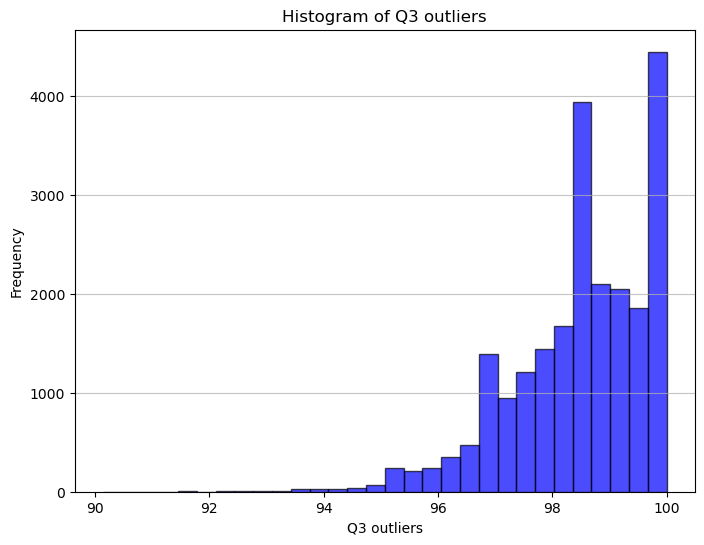

In [54]:
# Plot a histogram for the 'q1_gaps' column
variable = 'q3_outliers'
label = variable.lower().replace('_', ' ').capitalize()
plt.figure(figsize=(8, 6))
plt.hist(df_qc_info[variable], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Histogram of {label}')
plt.xlabel(label)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
df_qc_info['quality_index'] = df_qc_info[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers']].mean(axis=1)

df_qc_info['quality_label'] = df_qc_info.apply(calculate_quality_label, axis=1)

df_qc_info['final_classif'] = df_qc_info.apply(
    lambda row: 'LQ' if row['quality_label'] in ['4 - Low Quality', '5 - Very Low Quality'] or row['preclassif'] == 'LQ' else 'HQ',
    axis=1
)

df_qc_info.sort_values(['gauge_code', 'year'], inplace=True)

In [56]:
df_qc_info.to_hdf(cemaden_path, key = 'table_qc_info', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_qc_info

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,quality_index,quality_label,final_classif
0,110018901A,2018,,37.260274,100.0,79.213015,98.082192,78.638870,4 - Low Quality,LQ
1,110018901A,2019,,100.000000,100.0,91.236742,97.808219,97.261240,1 - Excellent Quality,HQ
2,110018901A,2020,LQ,100.000000,100.0,67.725139,100.000000,91.931285,1 - Excellent Quality,LQ
3,110020501A,2014,LQ,4.383562,100.0,65.984933,100.000000,67.592124,4 - Low Quality,LQ
4,110020501A,2017,LQ,25.205479,100.0,61.509982,100.000000,71.678865,4 - Low Quality,LQ
...,...,...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,,24.657534,100.0,90.159144,98.904110,78.430197,4 - Low Quality,LQ
22769,CEMADEN_12,2020,,8.469945,100.0,88.614499,99.453552,74.134499,4 - Low Quality,LQ
22770,CEMADEN_13,2019,LQ,8.219178,100.0,64.644661,99.726027,68.147467,4 - Low Quality,LQ
22771,CEMADEN_14,2018,,25.205479,100.0,78.723842,98.356164,75.571371,4 - Low Quality,LQ


# Visual Analysis

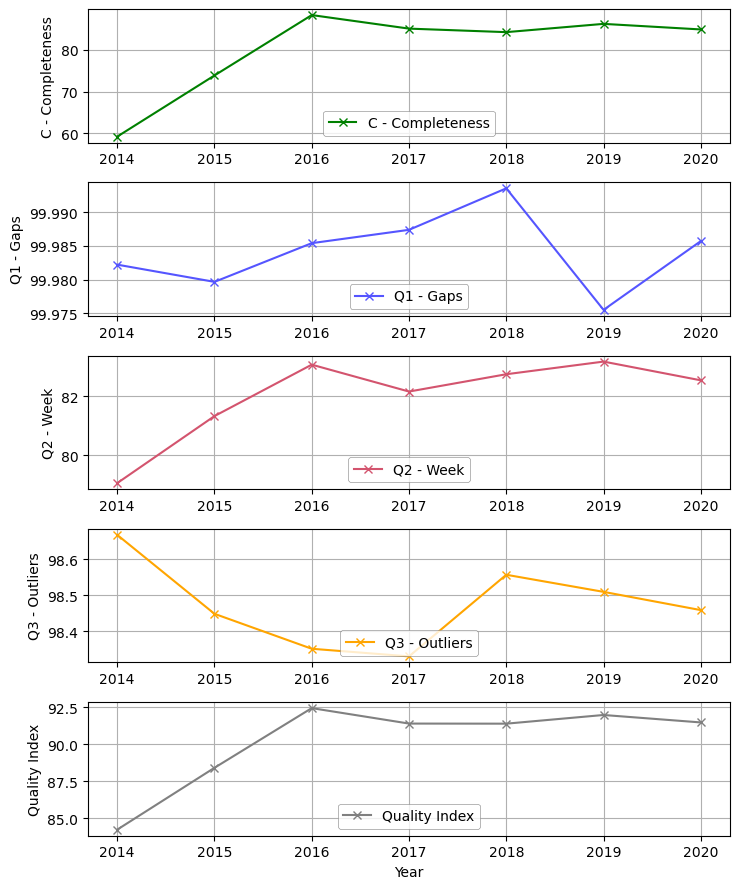

In [57]:
# Calculate the average value of each parameter by year
df_avg_params = df_qc_info.groupby('year').agg({
    'p_availability': 'mean',
    'q1_gaps': 'mean',
    'q2_week': 'mean',
    'q3_outliers': 'mean',
    'quality_index': 'mean'
}).reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(5, 1, figsize=(7.5, 9), sharex=True)

# Plot each parameter
ax0 = ax[0]
ax0.plot(df_avg_params['year'], df_avg_params['p_availability'], marker='x', color='g', label='C - Completeness')
ax0.set_ylabel('C - Completeness')
ax0.grid(True)
lines, labels = ax0.get_legend_handles_labels()
legend = ax0.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax1 = ax[1]
ax1.plot(df_avg_params['year'], df_avg_params['q1_gaps'], marker='x', color='#5555ff', label='Q1 - Gaps')
ax1.set_ylabel('Q1 - Gaps')
ax1.grid(True)
lines, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax2 = ax[2]
ax2.plot(df_avg_params['year'], df_avg_params['q2_week'], marker='x', color='#d3546e', label='Q2 - Week')
ax2.set_ylabel('Q2 - Week')
ax2.grid(True)
lines, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax3 = ax[3]
ax3.ylim = (97, None)
ax3.plot(df_avg_params['year'], df_avg_params['q3_outliers'], marker='x', color='Orange', label='Q3 - Outliers')
ax3.set_ylabel('Q3 - Outliers')
ax3.grid(True)
lines, labels = ax3.get_legend_handles_labels()
legend = ax3.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

ax4 = ax[4]
ax4.plot(df_avg_params['year'], df_avg_params['quality_index'], marker='x', color='grey', label='Quality Index')
ax4.set_xlabel('Year')
ax4.set_ylabel('Quality Index')
ax4.grid(True)
lines, labels = ax4.get_legend_handles_labels()

legend = ax4.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

# Show xticks on all subplots
for a in ax:
    a.label_outer()  # Hides labels except for the last subplot but keeps ticks visible
    a.tick_params(axis='x', which='both', labelbottom=True)  # Ensure xticks are visible
    
plt.tight_layout()
plt.savefig('./figures/quality_index_avg_year_cemaden.tiff', dpi = 300, bbox_inches='tight')
plt.show()
plt.close()

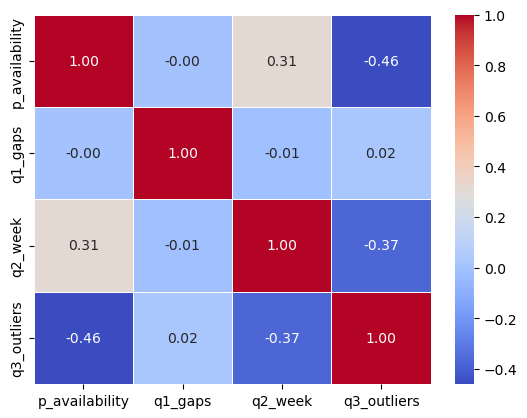

In [ ]:
# Select relevant columns for the heatmap
heatmap_data = df_qc_info[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers']]

# Calculate the correlation matrix
corr = heatmap_data.corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Heatmap of df_qc_info Parameters')
plt.show() 

In [59]:
df_qc_count = df_qc_info.groupby('quality_label').size().reset_index(name='count')
df_qc_count['percent'] = (df_qc_count['count'] / df_qc_count['count'].sum()) * 100
df_qc_count

,quality_label,count,percent
0,1 - Excellent Quality,12455,54.691960
1,2 - Good Quality,1336,5.866596
2,3 - Acceptable Quality,1443,6.336451
3,4 - Low Quality,7539,33.104993


In [60]:
df_qc_avg = df_qc_info.groupby('quality_label').agg({'p_availability': 'mean'
                                                     , 'q1_gaps':'mean'
                                                     , 'q2_week':'mean'
                                                     , 'q3_outliers':'mean'
                                                     }).reset_index()
df_qc_avg

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers
0,1 - Excellent Quality,99.978021,99.989443,85.735562,98.054193
1,2 - Good Quality,97.500673,99.982179,77.141090,98.681619
2,3 - Acceptable Quality,92.187047,99.962124,82.055216,98.291373
3,4 - Low Quality,47.124356,99.981159,77.361953,99.135528


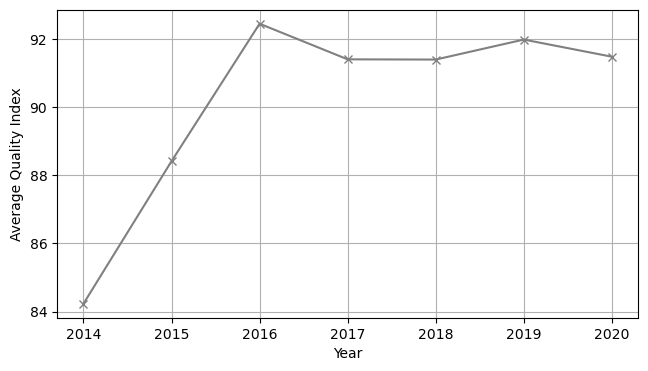

In [61]:
# Calculate the average quality index over the years
df_avg_quality_index = df_qc_info.groupby('year')['quality_index'].mean().reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(7.5, 4))

# Plot the average quality index over the years
ax.plot(df_avg_quality_index['year'], df_avg_quality_index['quality_index'], marker='x', color='grey', label='Average Quality Index')

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index Over the Years')
ax.grid(True)

plt.savefig('./figures/quality_index_over_the_years_cemaden.png', dpi=1800, bbox_inches='tight')
plt.show()
plt.close()

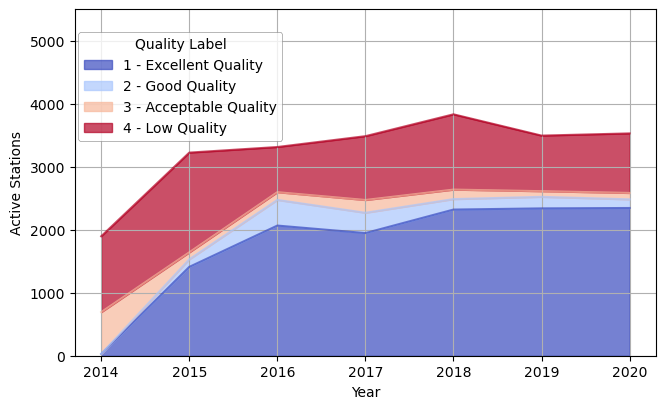

In [62]:

# Group by year and quality label to get the count of active stations
df_active_stations = df_qc_info.groupby(['year', 'quality_label']).size().unstack(fill_value=0)

# Create a stacked area plot with updated figure size
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Use a colorblind-friendly colormap
df_active_stations.plot(kind='area', stacked=True, ax=ax, colormap='coolwarm', alpha=0.7)

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Active Stations')
# ax.set_title('Count of Active Stations by Year and Quality Label')
ax.grid(True)
ax.set_ylim(0, 5500)
# Modify the EXISTING legend from pandas plot
legend = ax.legend()
legend.set_title('Quality Label')  # Set title
legend.set_bbox_to_anchor((0.369, 0.6))  # Set legend position
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

plt.savefig('./figures/active_stations_by_year_and_quality_label_cemaden.tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [63]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2025-04-19 22:43:19
